In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# One time installation.
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2023-10-02 05:33:15] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-10-02 05:33:15] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-02 05:33:21] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-10-02 05:33:25] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-02 05:33:25] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-02 05:33:25] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-10-02 05:33:25] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-10-02 05:33:25] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-10-02 05:33:25] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-10-02 05:33:25] WARNING

In [ ]:
cd /content/drive/MyDrive/aa


In [ ]:
# Define the path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/aa/Aerial Person Detection.v3-changed-labels.yolov8 (2).zip'

# Define the directory where you want to unzip the file
unzip_dir = '/content/drive/MyDrive/aa'



# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# You can now access the unzipped files in the 'unzip_dir' directory

/content/drive/MyDrive/aa


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/Aerial Person Detection.v3-changed-labels.yolov8'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['person',
   'person',
   'person',
   'person',
   'person',
   'person']

In [ ]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

In [ ]:
# Global parameters.
EPOCHS = 90
BATCH_SIZE = 8
WORKERS = 8

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

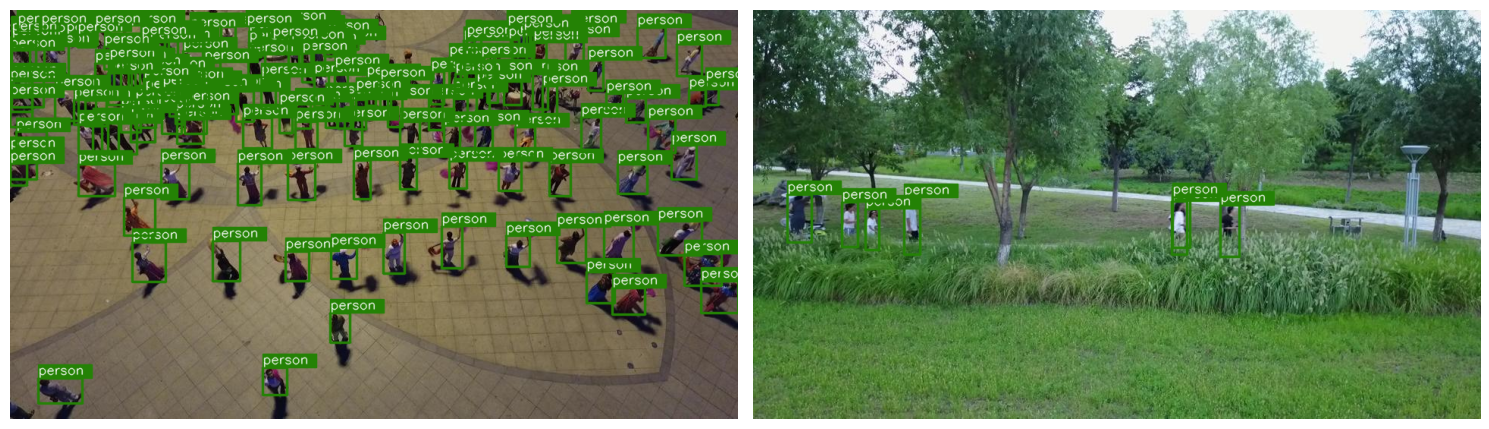

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=2,
)

In [ ]:

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2023-10-02 05:38:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 217/217 [00:56<00:00,  3.84it/s]
[2023-10-02 05:39:12] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 41/41 [00:49<00:00,  1.20s/it]
[2023-10-02 05:40:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  90%|█████████ | 9/10 [00:14<00:01,  1.80s/it]

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [ ]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms


[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

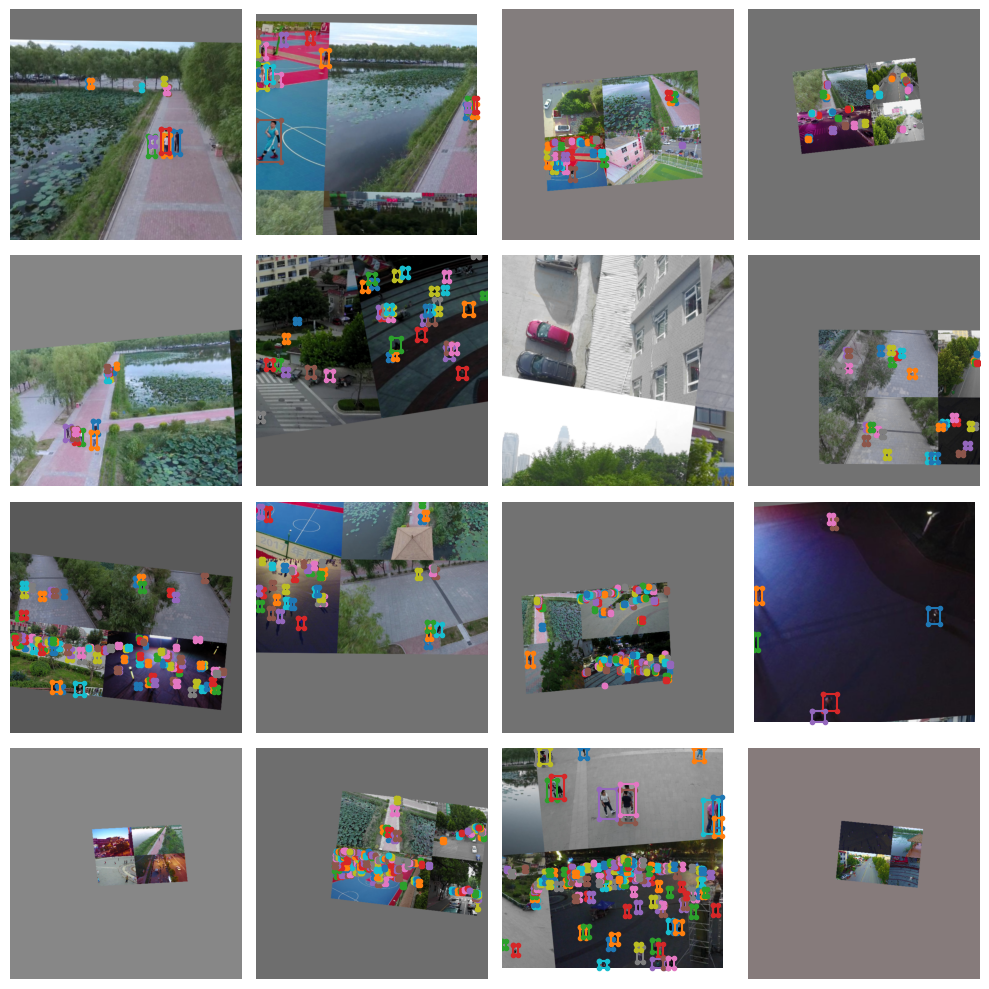

In [ ]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
models_to_train = [
    'yolo_nas_s',

]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train,
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2023-10-02 05:40:44] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:05<00:00, 12.9MB/s]
[2023-10-02 05:40:52] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


The console stream is now moved to checkpoints/yolo_nas_s/console_Oct02_05_41_01.txt


[2023-10-02 05:41:01] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-10-02 05:41:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 213        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         26         (len(train_loader))
    - Gradient updates per epoch:   26         (len(train_loader) / batch_accumulate)

[2023-10-02 05:41:11] INFO - sg_trainer.py - Started training for 90 epochs (0/89)

Validating: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
[2023-10-02 05:41:53] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.0495
│   ├── Ppyoloeloss/loss_iou = 0.4223
│   ├── Ppyoloeloss/loss_dfl = 1.1681
│   └── Ppyoloeloss/loss = 3.6892
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7935
    ├── Ppyoloeloss/loss_iou = 0.4006
    ├── Ppyoloeloss/loss_dfl = 0.8877
    ├── Ppyoloeloss/loss = 3.2387
    ├── Precision@0.50 = 0.0139
    ├── Recall@0.50 = 0.018
    ├── Map@0.50 = 0.0014
    ├── F1@0.50 = 0.0157
    ├── Precision@0.50:0.95 = 0.0039
    ├── Recall@0.50:0.95 = 0.0051
    ├── Map@0.50:0.95 = 0.0005
    └── F1@0.50:0.95 = 0.0044



Validating epoch 1: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]
[2023-10-02 05:42:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:42:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.019375493749976158


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0303
│   │   ├── Epoch N-1      = 2.0495 (↘ -1.0192)
│   │   └── Best until now = 2.0495 (↘ -1.0192)
│   ├── Ppyoloeloss/loss_iou = 0.3596
│   │   ├── Epoch N-1      = 0.4223 (↘ -0.0627)
│   │   └── Best until now = 0.4223 (↘ -0.0627)
│   ├── Ppyoloeloss/loss_dfl = 0.9167
│   │   ├── Epoch N-1      = 1.1681 (↘ -0.2514)
│   │   └── Best until now = 1.1681 (↘ -0.2514)
│   └── Ppyoloeloss/loss = 2.3876
│       ├── Epoch N-1      = 3.6892 (↘ -1.3016)
│       └── Best until now = 3.6892 (↘ -1.3016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4145
    │   ├── Epoch N-1      = 1.7935 (↘ -0.379)
    │   └── Best until now = 1.7935 (↘ -0.379)
    ├── Ppyoloeloss/loss_iou = 0.3822
    │   ├── Epoch N-1      = 0.4006 (↘ -0.0184)
    │   └── Best until now = 0.4006 (↘ -0.0184)
    ├── Ppyoloeloss/loss_dfl = 0.7895
    │   ├── Epoch N-1      = 0.8877 (↘ -0.0982)
    │   └── Best until now = 0.8877 (↘ -0.0982)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9167
│   │   ├── Epoch N-1      = 1.0303 (↘ -0.1136)
│   │   └── Best until now = 1.0303 (↘ -0.1136)
│   ├── Ppyoloeloss/loss_iou = 0.3488
│   │   ├── Epoch N-1      = 0.3596 (↘ -0.0108)
│   │   └── Best until now = 0.3596 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.8599
│   │   ├── Epoch N-1      = 0.9167 (↘ -0.0568)
│   │   └── Best until now = 0.9167 (↘ -0.0568)
│   └── Ppyoloeloss/loss = 2.2186
│       ├── Epoch N-1      = 2.3876 (↘ -0.169)
│       └── Best until now = 2.3876 (↘ -0.169)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2294
    │   ├── Epoch N-1      = 1.4145 (↘ -0.1852)
    │   └── Best until now = 1.4145 (↘ -0.1852)
    ├── Ppyoloeloss/loss_iou = 0.38
    │   ├── Epoch N-1      = 0.3822 (↘ -0.0023)
    │   └── Best until now = 0.3822 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.801
    │   ├── Epoch N-1      = 0.7895 (↗ 0.0115)
    │   └── Best until now = 0.7895 (↗ 0.0115)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 3: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]
[2023-10-02 05:43:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:43:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.026647482067346573


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.939
│   │   ├── Epoch N-1      = 0.9167 (↗ 0.0223)
│   │   └── Best until now = 0.9167 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_iou = 0.3526
│   │   ├── Epoch N-1      = 0.3488 (↗ 0.0038)
│   │   └── Best until now = 0.3488 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.8931
│   │   ├── Epoch N-1      = 0.8599 (↗ 0.0333)
│   │   └── Best until now = 0.8599 (↗ 0.0333)
│   └── Ppyoloeloss/loss = 2.2671
│       ├── Epoch N-1      = 2.2186 (↗ 0.0485)
│       └── Best until now = 2.2186 (↗ 0.0485)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4471
    │   ├── Epoch N-1      = 1.2294 (↗ 0.2178)
    │   └── Best until now = 1.2294 (↗ 0.2178)
    ├── Ppyoloeloss/loss_iou = 0.369
    │   ├── Epoch N-1      = 0.38   (↘ -0.0109)
    │   └── Best until now = 0.38   (↘ -0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.826
    │   ├── Epoch N-1      = 0.801  (↗ 0.025)
    │   └── Best until now = 0.7895 (↗ 0.0365)
    ├── Ppyoloeloss/loss = 2.7827
    

Validating epoch 4: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
[2023-10-02 05:44:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:44:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.027657991275191307


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8988
│   │   ├── Epoch N-1      = 0.939  (↘ -0.0402)
│   │   └── Best until now = 0.9167 (↘ -0.0179)
│   ├── Ppyoloeloss/loss_iou = 0.3307
│   │   ├── Epoch N-1      = 0.3526 (↘ -0.022)
│   │   └── Best until now = 0.3488 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.8568
│   │   ├── Epoch N-1      = 0.8931 (↘ -0.0363)
│   │   └── Best until now = 0.8599 (↘ -0.003)
│   └── Ppyoloeloss/loss = 2.154
│       ├── Epoch N-1      = 2.2671 (↘ -0.1132)
│       └── Best until now = 2.2186 (↘ -0.0646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9962
    │   ├── Epoch N-1      = 1.4471 (↘ -0.4509)
    │   └── Best until now = 1.2294 (↘ -0.2332)
    ├── Ppyoloeloss/loss_iou = 0.3586
    │   ├── Epoch N-1      = 0.369  (↘ -0.0105)
    │   └── Best until now = 0.369  (↘ -0.0105)
    ├── Ppyoloeloss/loss_dfl = 0.8507
    │   ├── Epoch N-1      = 0.826  (↗ 0.0246)
    │   └── Best until now = 0.7895 (↗ 0.0612)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
[2023-10-02 05:45:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:45:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.033770397305488586


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8747
│   │   ├── Epoch N-1      = 0.8988 (↘ -0.0241)
│   │   └── Best until now = 0.8988 (↘ -0.0241)
│   ├── Ppyoloeloss/loss_iou = 0.319
│   │   ├── Epoch N-1      = 0.3307 (↘ -0.0117)
│   │   └── Best until now = 0.3307 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.8053
│   │   ├── Epoch N-1      = 0.8568 (↘ -0.0515)
│   │   └── Best until now = 0.8568 (↘ -0.0515)
│   └── Ppyoloeloss/loss = 2.0747
│       ├── Epoch N-1      = 2.154  (↘ -0.0792)
│       └── Best until now = 2.154  (↘ -0.0792)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9825
    │   ├── Epoch N-1      = 0.9962 (↘ -0.0137)
    │   └── Best until now = 0.9962 (↘ -0.0137)
    ├── Ppyoloeloss/loss_iou = 0.3585
    │   ├── Epoch N-1      = 0.3586 (↘ -1e-04)
    │   └── Best until now = 0.3586 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.7585
    │   ├── Epoch N-1      = 0.8507 (↘ -0.0921)
    │   └── Best until now = 0.7895 (↘ -0.031)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
[2023-10-02 05:45:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:45:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.03509237617254257


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8668
│   │   ├── Epoch N-1      = 0.8747 (↘ -0.0079)
│   │   └── Best until now = 0.8747 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.3265
│   │   ├── Epoch N-1      = 0.319  (↗ 0.0076)
│   │   └── Best until now = 0.319  (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.8016
│   │   ├── Epoch N-1      = 0.8053 (↘ -0.0037)
│   │   └── Best until now = 0.8053 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 2.0839
│       ├── Epoch N-1      = 2.0747 (↗ 0.0092)
│       └── Best until now = 2.0747 (↗ 0.0092)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9885
    │   ├── Epoch N-1      = 0.9825 (↗ 0.006)
    │   └── Best until now = 0.9825 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.3505
    │   ├── Epoch N-1      = 0.3585 (↘ -0.0081)
    │   └── Best until now = 0.3585 (↘ -0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.78
    │   ├── Epoch N-1      = 0.7585 (↗ 0.0215)
    │   └── Best until now = 0.7585 (↗ 0.0215)
    ├── Ppyoloeloss/loss = 2.2546


Validating epoch 7: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
[2023-10-02 05:46:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:46:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.03890470415353775


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.846
│   │   ├── Epoch N-1      = 0.8668 (↘ -0.0207)
│   │   └── Best until now = 0.8668 (↘ -0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.3103
│   │   ├── Epoch N-1      = 0.3265 (↘ -0.0162)
│   │   └── Best until now = 0.319  (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.7753
│   │   ├── Epoch N-1      = 0.8016 (↘ -0.0263)
│   │   └── Best until now = 0.8016 (↘ -0.0263)
│   └── Ppyoloeloss/loss = 2.0094
│       ├── Epoch N-1      = 2.0839 (↘ -0.0745)
│       └── Best until now = 2.0747 (↘ -0.0653)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9673
    │   ├── Epoch N-1      = 0.9885 (↘ -0.0212)
    │   └── Best until now = 0.9825 (↘ -0.0153)
    ├── Ppyoloeloss/loss_iou = 0.3424
    │   ├── Epoch N-1      = 0.3505 (↘ -0.008)
    │   └── Best until now = 0.3505 (↘ -0.008)
    ├── Ppyoloeloss/loss_dfl = 0.7494
    │   ├── Epoch N-1      = 0.78   (↘ -0.0306)
    │   └── Best until now = 0.7585 (↘ -0.0091)
    ├── Ppyoloeloss/loss 

Validating epoch 8: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8404
│   │   ├── Epoch N-1      = 0.846  (↘ -0.0056)
│   │   └── Best until now = 0.846  (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.3095
│   │   ├── Epoch N-1      = 0.3103 (↘ -0.0008)
│   │   └── Best until now = 0.3103 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.7746
│   │   ├── Epoch N-1      = 0.7753 (↘ -0.0007)
│   │   └── Best until now = 0.7753 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 2.0014
│       ├── Epoch N-1      = 2.0094 (↘ -0.0081)
│       └── Best until now = 2.0094 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9603
    │   ├── Epoch N-1      = 0.9673 (↘ -0.007)
    │   └── Best until now = 0.9673 (↘ -0.007)
    ├── Ppyoloeloss/loss_iou = 0.3357
    │   ├── Epoch N-1      = 0.3424 (↘ -0.0067)
    │   └── Best until now = 0.3424 (↘ -0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.7786
    │   ├── Epoch N-1      = 0.7494 (↗ 0.0293)
    │   └── Best until now = 0.7494 (↗ 0.0293)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
[2023-10-02 05:47:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:47:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04307045042514801


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8435
│   │   ├── Epoch N-1      = 0.8404 (↗ 0.0031)
│   │   └── Best until now = 0.8404 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.3093
│   │   ├── Epoch N-1      = 0.3095 (↘ -0.0002)
│   │   └── Best until now = 0.3095 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.779
│   │   ├── Epoch N-1      = 0.7746 (↗ 0.0044)
│   │   └── Best until now = 0.7746 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 2.0063
│       ├── Epoch N-1      = 2.0014 (↗ 0.005)
│       └── Best until now = 2.0014 (↗ 0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9466
    │   ├── Epoch N-1      = 0.9603 (↘ -0.0138)
    │   └── Best until now = 0.9603 (↘ -0.0138)
    ├── Ppyoloeloss/loss_iou = 0.3342
    │   ├── Epoch N-1      = 0.3357 (↘ -0.0015)
    │   └── Best until now = 0.3357 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7485
    │   ├── Epoch N-1      = 0.7786 (↘ -0.0302)
    │   └── Best until now = 0.7494 (↘ -0.0009)
    ├── Ppyoloeloss/loss = 2.15

Validating epoch 10: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
[2023-10-02 05:48:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:48:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04415874555706978


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8582
│   │   ├── Epoch N-1      = 0.8435 (↗ 0.0147)
│   │   └── Best until now = 0.8404 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.2998
│   │   ├── Epoch N-1      = 0.3093 (↘ -0.0095)
│   │   └── Best until now = 0.3093 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.7906
│   │   ├── Epoch N-1      = 0.779  (↗ 0.0116)
│   │   └── Best until now = 0.7746 (↗ 0.016)
│   └── Ppyoloeloss/loss = 2.0029
│       ├── Epoch N-1      = 2.0063 (↘ -0.0034)
│       └── Best until now = 2.0014 (↗ 0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9554
    │   ├── Epoch N-1      = 0.9466 (↗ 0.0089)
    │   └── Best until now = 0.9466 (↗ 0.0089)
    ├── Ppyoloeloss/loss_iou = 0.3306
    │   ├── Epoch N-1      = 0.3342 (↘ -0.0036)
    │   └── Best until now = 0.3342 (↘ -0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.739
    │   ├── Epoch N-1      = 0.7485 (↘ -0.0094)
    │   └── Best until now = 0.7485 (↘ -0.0094)
    ├── Ppyoloeloss/loss = 2.1

Validating epoch 11: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8631
│   │   ├── Epoch N-1      = 0.8582 (↗ 0.005)
│   │   └── Best until now = 0.8404 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.3118
│   │   ├── Epoch N-1      = 0.2998 (↗ 0.012)
│   │   └── Best until now = 0.2998 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.783
│   │   ├── Epoch N-1      = 0.7906 (↘ -0.0077)
│   │   └── Best until now = 0.7746 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 2.034
│       ├── Epoch N-1      = 2.0029 (↗ 0.0311)
│       └── Best until now = 2.0014 (↗ 0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0236
    │   ├── Epoch N-1      = 0.9554 (↗ 0.0681)
    │   └── Best until now = 0.9466 (↗ 0.077)
    ├── Ppyoloeloss/loss_iou = 0.37
    │   ├── Epoch N-1      = 0.3306 (↗ 0.0394)
    │   └── Best until now = 0.3306 (↗ 0.0394)
    ├── Ppyoloeloss/loss_dfl = 0.7745
    │   ├── Epoch N-1      = 0.739  (↗ 0.0354)
    │   └── Best until now = 0.739  (↗ 0.0354)
    ├── Ppyoloeloss/loss = 2.3359
    │   

Validating epoch 12: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8233
│   │   ├── Epoch N-1      = 0.8631 (↘ -0.0398)
│   │   └── Best until now = 0.8404 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.2987
│   │   ├── Epoch N-1      = 0.3118 (↘ -0.0131)
│   │   └── Best until now = 0.2998 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.762
│   │   ├── Epoch N-1      = 0.783  (↘ -0.0209)
│   │   └── Best until now = 0.7746 (↘ -0.0126)
│   └── Ppyoloeloss/loss = 1.951
│       ├── Epoch N-1      = 2.034  (↘ -0.083)
│       └── Best until now = 2.0014 (↘ -0.0504)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9653
    │   ├── Epoch N-1      = 1.0236 (↘ -0.0583)
    │   └── Best until now = 0.9466 (↗ 0.0187)
    ├── Ppyoloeloss/loss_iou = 0.3423
    │   ├── Epoch N-1      = 0.37   (↘ -0.0278)
    │   └── Best until now = 0.3306 (↗ 0.0117)
    ├── Ppyoloeloss/loss_dfl = 0.7527
    │   ├── Epoch N-1      = 0.7745 (↘ -0.0218)
    │   └── Best until now = 0.739  (↗ 0.0136)
    ├── Ppyoloeloss/loss = 

Validating epoch 13: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8326
│   │   ├── Epoch N-1      = 0.8233 (↗ 0.0093)
│   │   └── Best until now = 0.8233 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.3018
│   │   ├── Epoch N-1      = 0.2987 (↗ 0.0032)
│   │   └── Best until now = 0.2987 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7753
│   │   ├── Epoch N-1      = 0.762  (↗ 0.0133)
│   │   └── Best until now = 0.762  (↗ 0.0133)
│   └── Ppyoloeloss/loss = 1.9748
│       ├── Epoch N-1      = 1.951  (↗ 0.0239)
│       └── Best until now = 1.951  (↗ 0.0239)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9225
    │   ├── Epoch N-1      = 0.9653 (↘ -0.0427)
    │   └── Best until now = 0.9466 (↘ -0.024)
    ├── Ppyoloeloss/loss_iou = 0.3348
    │   ├── Epoch N-1      = 0.3423 (↘ -0.0074)
    │   └── Best until now = 0.3306 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.7516
    │   ├── Epoch N-1      = 0.7527 (↘ -0.001)
    │   └── Best until now = 0.739  (↗ 0.0126)
    ├── Ppyoloeloss/loss = 2.1355

Validating epoch 14: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8375
│   │   ├── Epoch N-1      = 0.8326 (↗ 0.0049)
│   │   └── Best until now = 0.8233 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_iou = 0.3032
│   │   ├── Epoch N-1      = 0.3018 (↗ 0.0014)
│   │   └── Best until now = 0.2987 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.7521
│   │   ├── Epoch N-1      = 0.7753 (↘ -0.0232)
│   │   └── Best until now = 0.762  (↘ -0.01)
│   └── Ppyoloeloss/loss = 1.9716
│       ├── Epoch N-1      = 1.9748 (↘ -0.0032)
│       └── Best until now = 1.951  (↗ 0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9412
    │   ├── Epoch N-1      = 0.9225 (↗ 0.0186)
    │   └── Best until now = 0.9225 (↗ 0.0186)
    ├── Ppyoloeloss/loss_iou = 0.3416
    │   ├── Epoch N-1      = 0.3348 (↗ 0.0068)
    │   └── Best until now = 0.3306 (↗ 0.011)
    ├── Ppyoloeloss/loss_dfl = 0.7499
    │   ├── Epoch N-1      = 0.7516 (↘ -0.0018)
    │   └── Best until now = 0.739  (↗ 0.0108)
    ├── Ppyoloeloss/loss = 2.1702


Validating epoch 15: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
[2023-10-02 05:52:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:52:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04467570409178734


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8291
│   │   ├── Epoch N-1      = 0.8375 (↘ -0.0084)
│   │   └── Best until now = 0.8233 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.3004
│   │   ├── Epoch N-1      = 0.3032 (↘ -0.0028)
│   │   └── Best until now = 0.2987 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7573
│   │   ├── Epoch N-1      = 0.7521 (↗ 0.0052)
│   │   └── Best until now = 0.7521 (↗ 0.0052)
│   └── Ppyoloeloss/loss = 1.9589
│       ├── Epoch N-1      = 1.9716 (↘ -0.0127)
│       └── Best until now = 1.951  (↗ 0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9355
    │   ├── Epoch N-1      = 0.9412 (↘ -0.0056)
    │   └── Best until now = 0.9225 (↗ 0.013)
    ├── Ppyoloeloss/loss_iou = 0.3482
    │   ├── Epoch N-1      = 0.3416 (↗ 0.0066)
    │   └── Best until now = 0.3306 (↗ 0.0176)
    ├── Ppyoloeloss/loss_dfl = 0.744
    │   ├── Epoch N-1      = 0.7499 (↘ -0.0059)
    │   └── Best until now = 0.739  (↗ 0.0049)
    ├── Ppyoloeloss/loss = 2.178

Validating epoch 16: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8259
│   │   ├── Epoch N-1      = 0.8291 (↘ -0.0032)
│   │   └── Best until now = 0.8233 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.2895
│   │   ├── Epoch N-1      = 0.3004 (↘ -0.0109)
│   │   └── Best until now = 0.2987 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.7461
│   │   ├── Epoch N-1      = 0.7573 (↘ -0.0112)
│   │   └── Best until now = 0.7521 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.9228
│       ├── Epoch N-1      = 1.9589 (↘ -0.0361)
│       └── Best until now = 1.951  (↘ -0.0282)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8998
    │   ├── Epoch N-1      = 0.9355 (↘ -0.0358)
    │   └── Best until now = 0.9225 (↘ -0.0228)
    ├── Ppyoloeloss/loss_iou = 0.3398
    │   ├── Epoch N-1      = 0.3482 (↘ -0.0085)
    │   └── Best until now = 0.3306 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 0.748
    │   ├── Epoch N-1      = 0.744  (↗ 0.0041)
    │   └── Best until now = 0.739  (↗ 0.009)
    ├── Ppyoloeloss/loss = 2

Validating epoch 17: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
[2023-10-02 05:53:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:53:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04864950105547905


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8366
│   │   ├── Epoch N-1      = 0.8259 (↗ 0.0107)
│   │   └── Best until now = 0.8233 (↗ 0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.3039
│   │   ├── Epoch N-1      = 0.2895 (↗ 0.0144)
│   │   └── Best until now = 0.2895 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.7569
│   │   ├── Epoch N-1      = 0.7461 (↗ 0.0108)
│   │   └── Best until now = 0.7461 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.9748
│       ├── Epoch N-1      = 1.9228 (↗ 0.052)
│       └── Best until now = 1.9228 (↗ 0.052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9245
    │   ├── Epoch N-1      = 0.8998 (↗ 0.0247)
    │   └── Best until now = 0.8998 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.343
    │   ├── Epoch N-1      = 0.3398 (↗ 0.0032)
    │   └── Best until now = 0.3306 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.7368
    │   ├── Epoch N-1      = 0.748  (↘ -0.0112)
    │   └── Best until now = 0.739  (↘ -0.0022)
    ├── Ppyoloeloss/loss = 2.1503
  

Validating epoch 18: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8346
│   │   ├── Epoch N-1      = 0.8366 (↘ -0.002)
│   │   └── Best until now = 0.8233 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.2994
│   │   ├── Epoch N-1      = 0.3039 (↘ -0.0045)
│   │   └── Best until now = 0.2895 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.7528
│   │   ├── Epoch N-1      = 0.7569 (↘ -0.0041)
│   │   └── Best until now = 0.7461 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.9595
│       ├── Epoch N-1      = 1.9748 (↘ -0.0152)
│       └── Best until now = 1.9228 (↗ 0.0367)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9415
    │   ├── Epoch N-1      = 0.9245 (↗ 0.0171)
    │   └── Best until now = 0.8998 (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.3396
    │   ├── Epoch N-1      = 0.343  (↘ -0.0034)
    │   └── Best until now = 0.3306 (↗ 0.009)
    ├── Ppyoloeloss/loss_dfl = 0.7376
    │   ├── Epoch N-1      = 0.7368 (↗ 0.0007)
    │   └── Best until now = 0.7368 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 2.159

Validating epoch 19: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]
[2023-10-02 05:55:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:55:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.05527186393737793


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8202
│   │   ├── Epoch N-1      = 0.8346 (↘ -0.0145)
│   │   └── Best until now = 0.8233 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.2969
│   │   ├── Epoch N-1      = 0.2994 (↘ -0.0025)
│   │   └── Best until now = 0.2895 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.7469
│   │   ├── Epoch N-1      = 0.7528 (↘ -0.0059)
│   │   └── Best until now = 0.7461 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.9358
│       ├── Epoch N-1      = 1.9595 (↘ -0.0237)
│       └── Best until now = 1.9228 (↗ 0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9339
    │   ├── Epoch N-1      = 0.9415 (↘ -0.0076)
    │   └── Best until now = 0.8998 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.318
    │   ├── Epoch N-1      = 0.3396 (↘ -0.0216)
    │   └── Best until now = 0.3306 (↘ -0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.7127
    │   ├── Epoch N-1      = 0.7376 (↘ -0.0249)
    │   └── Best until now = 0.7368 (↘ -0.0241)
    ├── Ppyoloeloss/loss = 

Validating epoch 20: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8354
│   │   ├── Epoch N-1      = 0.8202 (↗ 0.0153)
│   │   └── Best until now = 0.8202 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.2926
│   │   ├── Epoch N-1      = 0.2969 (↘ -0.0043)
│   │   └── Best until now = 0.2895 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7746
│   │   ├── Epoch N-1      = 0.7469 (↗ 0.0277)
│   │   └── Best until now = 0.7461 (↗ 0.0285)
│   └── Ppyoloeloss/loss = 1.9542
│       ├── Epoch N-1      = 1.9358 (↗ 0.0184)
│       └── Best until now = 1.9228 (↗ 0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9484
    │   ├── Epoch N-1      = 0.9339 (↗ 0.0145)
    │   └── Best until now = 0.8998 (↗ 0.0487)
    ├── Ppyoloeloss/loss_iou = 0.3228
    │   ├── Epoch N-1      = 0.318  (↗ 0.0048)
    │   └── Best until now = 0.318  (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.7267
    │   ├── Epoch N-1      = 0.7127 (↗ 0.014)
    │   └── Best until now = 0.7127 (↗ 0.014)
    ├── Ppyoloeloss/loss = 2.1188
   

Validating epoch 21: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
[2023-10-02 05:56:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:56:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.056177567690610886


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8318
│   │   ├── Epoch N-1      = 0.8354 (↘ -0.0036)
│   │   └── Best until now = 0.8202 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.2992
│   │   ├── Epoch N-1      = 0.2926 (↗ 0.0066)
│   │   └── Best until now = 0.2895 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.7341
│   │   ├── Epoch N-1      = 0.7746 (↘ -0.0405)
│   │   └── Best until now = 0.7461 (↘ -0.012)
│   └── Ppyoloeloss/loss = 1.9469
│       ├── Epoch N-1      = 1.9542 (↘ -0.0074)
│       └── Best until now = 1.9228 (↗ 0.0241)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9456
    │   ├── Epoch N-1      = 0.9484 (↘ -0.0028)
    │   └── Best until now = 0.8998 (↗ 0.0459)
    ├── Ppyoloeloss/loss_iou = 0.329
    │   ├── Epoch N-1      = 0.3228 (↗ 0.0062)
    │   └── Best until now = 0.318  (↗ 0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.7171
    │   ├── Epoch N-1      = 0.7267 (↘ -0.0096)
    │   └── Best until now = 0.7127 (↗ 0.0044)
    ├── Ppyoloeloss/loss = 2.12

Validating epoch 22: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
[2023-10-02 05:57:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:57:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06192513182759285


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8262
│   │   ├── Epoch N-1      = 0.8318 (↘ -0.0056)
│   │   └── Best until now = 0.8202 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.2912
│   │   ├── Epoch N-1      = 0.2992 (↘ -0.008)
│   │   └── Best until now = 0.2895 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7462
│   │   ├── Epoch N-1      = 0.7341 (↗ 0.0121)
│   │   └── Best until now = 0.7341 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.9273
│       ├── Epoch N-1      = 1.9469 (↘ -0.0195)
│       └── Best until now = 1.9228 (↗ 0.0045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.908
    │   ├── Epoch N-1      = 0.9456 (↘ -0.0376)
    │   └── Best until now = 0.8998 (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.3147
    │   ├── Epoch N-1      = 0.329  (↘ -0.0142)
    │   └── Best until now = 0.318  (↘ -0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.7097
    │   ├── Epoch N-1      = 0.7171 (↘ -0.0074)
    │   └── Best until now = 0.7127 (↘ -0.003)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 23: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
[2023-10-02 05:58:12] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 05:58:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06261518597602844


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8083
│   │   ├── Epoch N-1      = 0.8262 (↘ -0.0179)
│   │   └── Best until now = 0.8202 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.2811
│   │   ├── Epoch N-1      = 0.2912 (↘ -0.0102)
│   │   └── Best until now = 0.2895 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.7411
│   │   ├── Epoch N-1      = 0.7462 (↘ -0.0051)
│   │   └── Best until now = 0.7341 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.8815
│       ├── Epoch N-1      = 1.9273 (↘ -0.0458)
│       └── Best until now = 1.9228 (↘ -0.0413)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8996
    │   ├── Epoch N-1      = 0.908  (↘ -0.0085)
    │   └── Best until now = 0.8998 (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.3142
    │   ├── Epoch N-1      = 0.3147 (↘ -0.0005)
    │   └── Best until now = 0.3147 (↘ -0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.7114
    │   ├── Epoch N-1      = 0.7097 (↗ 0.0017)
    │   └── Best until now = 0.7097 (↗ 0.0017)
    ├── Ppyoloeloss/loss 

Validating epoch 24: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8276
│   │   ├── Epoch N-1      = 0.8083 (↗ 0.0193)
│   │   └── Best until now = 0.8083 (↗ 0.0193)
│   ├── Ppyoloeloss/loss_iou = 0.2876
│   │   ├── Epoch N-1      = 0.2811 (↗ 0.0066)
│   │   └── Best until now = 0.2811 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.7464
│   │   ├── Epoch N-1      = 0.7411 (↗ 0.0053)
│   │   └── Best until now = 0.7341 (↗ 0.0123)
│   └── Ppyoloeloss/loss = 1.9198
│       ├── Epoch N-1      = 1.8815 (↗ 0.0383)
│       └── Best until now = 1.8815 (↗ 0.0383)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9632
    │   ├── Epoch N-1      = 0.8996 (↗ 0.0636)
    │   └── Best until now = 0.8996 (↗ 0.0636)
    ├── Ppyoloeloss/loss_iou = 0.3346
    │   ├── Epoch N-1      = 0.3142 (↗ 0.0204)
    │   └── Best until now = 0.3142 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.7309
    │   ├── Epoch N-1      = 0.7114 (↗ 0.0195)
    │   └── Best until now = 0.7097 (↗ 0.0212)
    ├── Ppyoloeloss/loss = 2.165
  

Validating epoch 25: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8242
│   │   ├── Epoch N-1      = 0.8276 (↘ -0.0034)
│   │   └── Best until now = 0.8083 (↗ 0.0158)
│   ├── Ppyoloeloss/loss_iou = 0.29
│   │   ├── Epoch N-1      = 0.2876 (↗ 0.0024)
│   │   └── Best until now = 0.2811 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.7318
│   │   ├── Epoch N-1      = 0.7464 (↘ -0.0145)
│   │   └── Best until now = 0.7341 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.9151
│       ├── Epoch N-1      = 1.9198 (↘ -0.0046)
│       └── Best until now = 1.8815 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9838
    │   ├── Epoch N-1      = 0.9632 (↗ 0.0207)
    │   └── Best until now = 0.8996 (↗ 0.0843)
    ├── Ppyoloeloss/loss_iou = 0.3383
    │   ├── Epoch N-1      = 0.3346 (↗ 0.0037)
    │   └── Best until now = 0.3142 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.7375
    │   ├── Epoch N-1      = 0.7309 (↗ 0.0066)
    │   └── Best until now = 0.7097 (↗ 0.0278)
    ├── Ppyoloeloss/loss = 2.1983


Validating epoch 26: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8028
│   │   ├── Epoch N-1      = 0.8242 (↘ -0.0213)
│   │   └── Best until now = 0.8083 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.2737
│   │   ├── Epoch N-1      = 0.29   (↘ -0.0163)
│   │   └── Best until now = 0.2811 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.7325
│   │   ├── Epoch N-1      = 0.7318 (↗ 0.0007)
│   │   └── Best until now = 0.7318 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.8535
│       ├── Epoch N-1      = 1.9151 (↘ -0.0617)
│       └── Best until now = 1.8815 (↘ -0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9298
    │   ├── Epoch N-1      = 0.9838 (↘ -0.0541)
    │   └── Best until now = 0.8996 (↗ 0.0302)
    ├── Ppyoloeloss/loss_iou = 0.3272
    │   ├── Epoch N-1      = 0.3383 (↘ -0.011)
    │   └── Best until now = 0.3142 (↗ 0.013)
    ├── Ppyoloeloss/loss_dfl = 0.7331
    │   ├── Epoch N-1      = 0.7375 (↘ -0.0045)
    │   └── Best until now = 0.7097 (↗ 0.0234)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 27: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.807
│   │   ├── Epoch N-1      = 0.8028 (↗ 0.0041)
│   │   └── Best until now = 0.8028 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2792
│   │   ├── Epoch N-1      = 0.2737 (↗ 0.0054)
│   │   └── Best until now = 0.2737 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.7301
│   │   ├── Epoch N-1      = 0.7325 (↘ -0.0024)
│   │   └── Best until now = 0.7318 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.87
│       ├── Epoch N-1      = 1.8535 (↗ 0.0165)
│       └── Best until now = 1.8535 (↗ 0.0165)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9185
    │   ├── Epoch N-1      = 0.9298 (↘ -0.0113)
    │   └── Best until now = 0.8996 (↗ 0.0189)
    ├── Ppyoloeloss/loss_iou = 0.3261
    │   ├── Epoch N-1      = 0.3272 (↘ -0.0011)
    │   └── Best until now = 0.3142 (↗ 0.0119)
    ├── Ppyoloeloss/loss_dfl = 0.7215
    │   ├── Epoch N-1      = 0.7331 (↘ -0.0115)
    │   └── Best until now = 0.7097 (↗ 0.0118)
    ├── Ppyoloeloss/loss = 2.0946

Validating epoch 28: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8106
│   │   ├── Epoch N-1      = 0.807  (↗ 0.0036)
│   │   └── Best until now = 0.8028 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.2836
│   │   ├── Epoch N-1      = 0.2792 (↗ 0.0044)
│   │   └── Best until now = 0.2737 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.7348
│   │   ├── Epoch N-1      = 0.7301 (↗ 0.0047)
│   │   └── Best until now = 0.7301 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.8871
│       ├── Epoch N-1      = 1.87   (↗ 0.0171)
│       └── Best until now = 1.8535 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9078
    │   ├── Epoch N-1      = 0.9185 (↘ -0.0107)
    │   └── Best until now = 0.8996 (↗ 0.0082)
    ├── Ppyoloeloss/loss_iou = 0.3146
    │   ├── Epoch N-1      = 0.3261 (↘ -0.0115)
    │   └── Best until now = 0.3142 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.7098
    │   ├── Epoch N-1      = 0.7215 (↘ -0.0117)
    │   └── Best until now = 0.7097 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 2.0493

Validating epoch 29: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7978
│   │   ├── Epoch N-1      = 0.8106 (↘ -0.0128)
│   │   └── Best until now = 0.8028 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.2764
│   │   ├── Epoch N-1      = 0.2836 (↘ -0.0072)
│   │   └── Best until now = 0.2737 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.7377
│   │   ├── Epoch N-1      = 0.7348 (↗ 0.0029)
│   │   └── Best until now = 0.7301 (↗ 0.0076)
│   └── Ppyoloeloss/loss = 1.8577
│       ├── Epoch N-1      = 1.8871 (↘ -0.0294)
│       └── Best until now = 1.8535 (↗ 0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9128
    │   ├── Epoch N-1      = 0.9078 (↗ 0.0051)
    │   └── Best until now = 0.8996 (↗ 0.0132)
    ├── Ppyoloeloss/loss_iou = 0.3197
    │   ├── Epoch N-1      = 0.3146 (↗ 0.005)
    │   └── Best until now = 0.3142 (↗ 0.0054)
    ├── Ppyoloeloss/loss_dfl = 0.7217
    │   ├── Epoch N-1      = 0.7098 (↗ 0.0119)
    │   └── Best until now = 0.7097 (↗ 0.012)
    ├── Ppyoloeloss/loss = 2.0728

Validating epoch 30: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8175
│   │   ├── Epoch N-1      = 0.7978 (↗ 0.0198)
│   │   └── Best until now = 0.7978 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.2882
│   │   ├── Epoch N-1      = 0.2764 (↗ 0.0117)
│   │   └── Best until now = 0.2737 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.7178
│   │   ├── Epoch N-1      = 0.7377 (↘ -0.02)
│   │   └── Best until now = 0.7301 (↘ -0.0124)
│   └── Ppyoloeloss/loss = 1.8968
│       ├── Epoch N-1      = 1.8577 (↗ 0.0391)
│       └── Best until now = 1.8535 (↗ 0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.948
    │   ├── Epoch N-1      = 0.9128 (↗ 0.0351)
    │   └── Best until now = 0.8996 (↗ 0.0484)
    ├── Ppyoloeloss/loss_iou = 0.3127
    │   ├── Epoch N-1      = 0.3197 (↘ -0.007)
    │   └── Best until now = 0.3142 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7057
    │   ├── Epoch N-1      = 0.7217 (↘ -0.016)
    │   └── Best until now = 0.7097 (↘ -0.004)
    ├── Ppyoloeloss/loss = 2.0825
 

Validating epoch 31: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8149
│   │   ├── Epoch N-1      = 0.8175 (↘ -0.0026)
│   │   └── Best until now = 0.7978 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.2882
│   │   ├── Epoch N-1      = 0.2882 (↗ 0.0)
│   │   └── Best until now = 0.2737 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_dfl = 0.7345
│   │   ├── Epoch N-1      = 0.7178 (↗ 0.0168)
│   │   └── Best until now = 0.7178 (↗ 0.0168)
│   └── Ppyoloeloss/loss = 1.9026
│       ├── Epoch N-1      = 1.8968 (↗ 0.0058)
│       └── Best until now = 1.8535 (↗ 0.0491)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9492
    │   ├── Epoch N-1      = 0.948  (↗ 0.0012)
    │   └── Best until now = 0.8996 (↗ 0.0496)
    ├── Ppyoloeloss/loss_iou = 0.324
    │   ├── Epoch N-1      = 0.3127 (↗ 0.0113)
    │   └── Best until now = 0.3127 (↗ 0.0113)
    ├── Ppyoloeloss/loss_dfl = 0.7235
    │   ├── Epoch N-1      = 0.7057 (↗ 0.0178)
    │   └── Best until now = 0.7057 (↗ 0.0178)
    ├── Ppyoloeloss/loss = 2.1209
    

Validating epoch 32: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7967
│   │   ├── Epoch N-1      = 0.8149 (↘ -0.0182)
│   │   └── Best until now = 0.7978 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.2823
│   │   ├── Epoch N-1      = 0.2882 (↘ -0.0059)
│   │   └── Best until now = 0.2737 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.7358
│   │   ├── Epoch N-1      = 0.7345 (↗ 0.0013)
│   │   └── Best until now = 0.7178 (↗ 0.018)
│   └── Ppyoloeloss/loss = 1.8703
│       ├── Epoch N-1      = 1.9026 (↘ -0.0323)
│       └── Best until now = 1.8535 (↗ 0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8728
    │   ├── Epoch N-1      = 0.9492 (↘ -0.0764)
    │   └── Best until now = 0.8996 (↘ -0.0267)
    ├── Ppyoloeloss/loss_iou = 0.316
    │   ├── Epoch N-1      = 0.324  (↘ -0.0079)
    │   └── Best until now = 0.3127 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.72
    │   ├── Epoch N-1      = 0.7235 (↘ -0.0035)
    │   └── Best until now = 0.7057 (↗ 0.0143)
    ├── Ppyoloeloss/loss = 2.02

Validating epoch 33: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8155
│   │   ├── Epoch N-1      = 0.7967 (↗ 0.0188)
│   │   └── Best until now = 0.7967 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_iou = 0.2804
│   │   ├── Epoch N-1      = 0.2823 (↘ -0.0019)
│   │   └── Best until now = 0.2737 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.7284
│   │   ├── Epoch N-1      = 0.7358 (↘ -0.0074)
│   │   └── Best until now = 0.7178 (↗ 0.0107)
│   └── Ppyoloeloss/loss = 1.8806
│       ├── Epoch N-1      = 1.8703 (↗ 0.0103)
│       └── Best until now = 1.8535 (↗ 0.0271)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9151
    │   ├── Epoch N-1      = 0.8728 (↗ 0.0423)
    │   └── Best until now = 0.8728 (↗ 0.0423)
    ├── Ppyoloeloss/loss_iou = 0.3267
    │   ├── Epoch N-1      = 0.316  (↗ 0.0106)
    │   └── Best until now = 0.3127 (↗ 0.014)
    ├── Ppyoloeloss/loss_dfl = 0.7265
    │   ├── Epoch N-1      = 0.72   (↗ 0.0064)
    │   └── Best until now = 0.7057 (↗ 0.0208)
    ├── Ppyoloeloss/loss = 2.095
 

Validating epoch 34: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.818
│   │   ├── Epoch N-1      = 0.8155 (↗ 0.0025)
│   │   └── Best until now = 0.7967 (↗ 0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.2862
│   │   ├── Epoch N-1      = 0.2804 (↗ 0.0059)
│   │   └── Best until now = 0.2737 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.7359
│   │   ├── Epoch N-1      = 0.7284 (↗ 0.0075)
│   │   └── Best until now = 0.7178 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.9015
│       ├── Epoch N-1      = 1.8806 (↗ 0.0209)
│       └── Best until now = 1.8535 (↗ 0.048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9316
    │   ├── Epoch N-1      = 0.9151 (↗ 0.0165)
    │   └── Best until now = 0.8728 (↗ 0.0588)
    ├── Ppyoloeloss/loss_iou = 0.3219
    │   ├── Epoch N-1      = 0.3267 (↘ -0.0048)
    │   └── Best until now = 0.3127 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.7234
    │   ├── Epoch N-1      = 0.7265 (↘ -0.003)
    │   └── Best until now = 0.7057 (↗ 0.0177)
    ├── Ppyoloeloss/loss = 2.0981
  

Validating epoch 35: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8143
│   │   ├── Epoch N-1      = 0.818  (↘ -0.0037)
│   │   └── Best until now = 0.7967 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.2895
│   │   ├── Epoch N-1      = 0.2862 (↗ 0.0032)
│   │   └── Best until now = 0.2737 (↗ 0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.7185
│   │   ├── Epoch N-1      = 0.7359 (↘ -0.0174)
│   │   └── Best until now = 0.7178 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.8971
│       ├── Epoch N-1      = 1.9015 (↘ -0.0044)
│       └── Best until now = 1.8535 (↗ 0.0437)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8918
    │   ├── Epoch N-1      = 0.9316 (↘ -0.0398)
    │   └── Best until now = 0.8728 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.3187
    │   ├── Epoch N-1      = 0.3219 (↘ -0.0032)
    │   └── Best until now = 0.3127 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.709
    │   ├── Epoch N-1      = 0.7234 (↘ -0.0145)
    │   └── Best until now = 0.7057 (↗ 0.0033)
    ├── Ppyoloeloss/loss = 2.04

Validating epoch 36: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
[2023-10-02 06:07:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:07:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06314144283533096


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8084
│   │   ├── Epoch N-1      = 0.8143 (↘ -0.0058)
│   │   └── Best until now = 0.7967 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.2797
│   │   ├── Epoch N-1      = 0.2895 (↘ -0.0098)
│   │   └── Best until now = 0.2737 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.7326
│   │   ├── Epoch N-1      = 0.7185 (↗ 0.0142)
│   │   └── Best until now = 0.7178 (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.874
│       ├── Epoch N-1      = 1.8971 (↘ -0.0232)
│       └── Best until now = 1.8535 (↗ 0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8822
    │   ├── Epoch N-1      = 0.8918 (↘ -0.0096)
    │   └── Best until now = 0.8728 (↗ 0.0094)
    ├── Ppyoloeloss/loss_iou = 0.3148
    │   ├── Epoch N-1      = 0.3187 (↘ -0.0039)
    │   └── Best until now = 0.3127 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.7042
    │   ├── Epoch N-1      = 0.709  (↘ -0.0048)
    │   └── Best until now = 0.7057 (↘ -0.0015)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 37: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
[2023-10-02 06:08:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:08:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06554856896400452


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8217
│   │   ├── Epoch N-1      = 0.8084 (↗ 0.0133)
│   │   └── Best until now = 0.7967 (↗ 0.025)
│   ├── Ppyoloeloss/loss_iou = 0.285
│   │   ├── Epoch N-1      = 0.2797 (↗ 0.0053)
│   │   └── Best until now = 0.2737 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.7241
│   │   ├── Epoch N-1      = 0.7326 (↘ -0.0085)
│   │   └── Best until now = 0.7178 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.8962
│       ├── Epoch N-1      = 1.874  (↗ 0.0223)
│       └── Best until now = 1.8535 (↗ 0.0427)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8907
    │   ├── Epoch N-1      = 0.8822 (↗ 0.0085)
    │   └── Best until now = 0.8728 (↗ 0.0179)
    ├── Ppyoloeloss/loss_iou = 0.3086
    │   ├── Epoch N-1      = 0.3148 (↘ -0.0062)
    │   └── Best until now = 0.3127 (↘ -0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.706
    │   ├── Epoch N-1      = 0.7042 (↗ 0.0018)
    │   └── Best until now = 0.7042 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 2.0153
 

Validating epoch 38: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8076
│   │   ├── Epoch N-1      = 0.8217 (↘ -0.0141)
│   │   └── Best until now = 0.7967 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.2788
│   │   ├── Epoch N-1      = 0.285  (↘ -0.0062)
│   │   └── Best until now = 0.2737 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.7214
│   │   ├── Epoch N-1      = 0.7241 (↘ -0.0027)
│   │   └── Best until now = 0.7178 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.8653
│       ├── Epoch N-1      = 1.8962 (↘ -0.0309)
│       └── Best until now = 1.8535 (↗ 0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9147
    │   ├── Epoch N-1      = 0.8907 (↗ 0.024)
    │   └── Best until now = 0.8728 (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.3185
    │   ├── Epoch N-1      = 0.3086 (↗ 0.0099)
    │   └── Best until now = 0.3086 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.7151
    │   ├── Epoch N-1      = 0.706  (↗ 0.0091)
    │   └── Best until now = 0.7042 (↗ 0.0109)
    ├── Ppyoloeloss/loss = 2.0685

Validating epoch 39: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8137
│   │   ├── Epoch N-1      = 0.8076 (↗ 0.0061)
│   │   └── Best until now = 0.7967 (↗ 0.017)
│   ├── Ppyoloeloss/loss_iou = 0.2844
│   │   ├── Epoch N-1      = 0.2788 (↗ 0.0056)
│   │   └── Best until now = 0.2737 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.7168
│   │   ├── Epoch N-1      = 0.7214 (↘ -0.0046)
│   │   └── Best until now = 0.7178 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.8831
│       ├── Epoch N-1      = 1.8653 (↗ 0.0179)
│       └── Best until now = 1.8535 (↗ 0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8825
    │   ├── Epoch N-1      = 0.9147 (↘ -0.0321)
    │   └── Best until now = 0.8728 (↗ 0.0097)
    ├── Ppyoloeloss/loss_iou = 0.3018
    │   ├── Epoch N-1      = 0.3185 (↘ -0.0168)
    │   └── Best until now = 0.3086 (↘ -0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.6988
    │   ├── Epoch N-1      = 0.7151 (↘ -0.0163)
    │   └── Best until now = 0.7042 (↘ -0.0054)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 40: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
[2023-10-02 06:10:53] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:10:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.06966584920883179


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8003
│   │   ├── Epoch N-1      = 0.8137 (↘ -0.0134)
│   │   └── Best until now = 0.7967 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.2691
│   │   ├── Epoch N-1      = 0.2844 (↘ -0.0153)
│   │   └── Best until now = 0.2737 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.7346
│   │   ├── Epoch N-1      = 0.7168 (↗ 0.0178)
│   │   └── Best until now = 0.7168 (↗ 0.0178)
│   └── Ppyoloeloss/loss = 1.8403
│       ├── Epoch N-1      = 1.8831 (↘ -0.0429)
│       └── Best until now = 1.8535 (↘ -0.0132)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9286
    │   ├── Epoch N-1      = 0.8825 (↗ 0.046)
    │   └── Best until now = 0.8728 (↗ 0.0557)
    ├── Ppyoloeloss/loss_iou = 0.3059
    │   ├── Epoch N-1      = 0.3018 (↗ 0.0042)
    │   └── Best until now = 0.3018 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.7006
    │   ├── Epoch N-1      = 0.6988 (↗ 0.0018)
    │   └── Best until now = 0.6988 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 2.04

Validating epoch 41: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8046
│   │   ├── Epoch N-1      = 0.8003 (↗ 0.0043)
│   │   └── Best until now = 0.7967 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.282
│   │   ├── Epoch N-1      = 0.2691 (↗ 0.013)
│   │   └── Best until now = 0.2691 (↗ 0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.7424
│   │   ├── Epoch N-1      = 0.7346 (↗ 0.0078)
│   │   └── Best until now = 0.7168 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.8809
│       ├── Epoch N-1      = 1.8403 (↗ 0.0406)
│       └── Best until now = 1.8403 (↗ 0.0406)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8832
    │   ├── Epoch N-1      = 0.9286 (↘ -0.0454)
    │   └── Best until now = 0.8728 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.3134
    │   ├── Epoch N-1      = 0.3059 (↗ 0.0075)
    │   └── Best until now = 0.3018 (↗ 0.0117)
    ├── Ppyoloeloss/loss_dfl = 0.7134
    │   ├── Epoch N-1      = 0.7006 (↗ 0.0128)
    │   └── Best until now = 0.6988 (↗ 0.0146)
    ├── Ppyoloeloss/loss = 2.0234
   

Validating epoch 42: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8144
│   │   ├── Epoch N-1      = 0.8046 (↗ 0.0097)
│   │   └── Best until now = 0.7967 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_iou = 0.2793
│   │   ├── Epoch N-1      = 0.282  (↘ -0.0027)
│   │   └── Best until now = 0.2691 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.7228
│   │   ├── Epoch N-1      = 0.7424 (↘ -0.0196)
│   │   └── Best until now = 0.7168 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.874
│       ├── Epoch N-1      = 1.8809 (↘ -0.0069)
│       └── Best until now = 1.8403 (↗ 0.0337)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.914
    │   ├── Epoch N-1      = 0.8832 (↗ 0.0309)
    │   └── Best until now = 0.8728 (↗ 0.0412)
    ├── Ppyoloeloss/loss_iou = 0.3105
    │   ├── Epoch N-1      = 0.3134 (↘ -0.0029)
    │   └── Best until now = 0.3018 (↗ 0.0088)
    ├── Ppyoloeloss/loss_dfl = 0.7002
    │   ├── Epoch N-1      = 0.7134 (↘ -0.0132)
    │   └── Best until now = 0.6988 (↗ 0.0014)
    ├── Ppyoloeloss/loss = 2.0405

Validating epoch 43: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
[2023-10-02 06:13:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:13:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07006283104419708


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7977
│   │   ├── Epoch N-1      = 0.8144 (↘ -0.0166)
│   │   └── Best until now = 0.7967 (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.2783
│   │   ├── Epoch N-1      = 0.2793 (↘ -0.001)
│   │   └── Best until now = 0.2691 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.6997
│   │   ├── Epoch N-1      = 0.7228 (↘ -0.0231)
│   │   └── Best until now = 0.7168 (↘ -0.0171)
│   └── Ppyoloeloss/loss = 1.8433
│       ├── Epoch N-1      = 1.874  (↘ -0.0307)
│       └── Best until now = 1.8403 (↗ 0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.924
    │   ├── Epoch N-1      = 0.914  (↗ 0.0099)
    │   └── Best until now = 0.8728 (↗ 0.0511)
    ├── Ppyoloeloss/loss_iou = 0.3093
    │   ├── Epoch N-1      = 0.3105 (↘ -0.0012)
    │   └── Best until now = 0.3018 (↗ 0.0076)
    ├── Ppyoloeloss/loss_dfl = 0.6956
    │   ├── Epoch N-1      = 0.7002 (↘ -0.0046)
    │   └── Best until now = 0.6988 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 44: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7926
│   │   ├── Epoch N-1      = 0.7977 (↘ -0.0052)
│   │   └── Best until now = 0.7967 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2756
│   │   ├── Epoch N-1      = 0.2783 (↘ -0.0027)
│   │   └── Best until now = 0.2691 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.7015
│   │   ├── Epoch N-1      = 0.6997 (↗ 0.0018)
│   │   └── Best until now = 0.6997 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.8322
│       ├── Epoch N-1      = 1.8433 (↘ -0.0111)
│       └── Best until now = 1.8403 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8904
    │   ├── Epoch N-1      = 0.924  (↘ -0.0335)
    │   └── Best until now = 0.8728 (↗ 0.0176)
    ├── Ppyoloeloss/loss_iou = 0.3039
    │   ├── Epoch N-1      = 0.3093 (↘ -0.0054)
    │   └── Best until now = 0.3018 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.6972
    │   ├── Epoch N-1      = 0.6956 (↗ 0.0015)
    │   └── Best until now = 0.6956 (↗ 0.0015)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 45: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7745
│   │   ├── Epoch N-1      = 0.7926 (↘ -0.018)
│   │   └── Best until now = 0.7926 (↘ -0.018)
│   ├── Ppyoloeloss/loss_iou = 0.2625
│   │   ├── Epoch N-1      = 0.2756 (↘ -0.013)
│   │   └── Best until now = 0.2691 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.7136
│   │   ├── Epoch N-1      = 0.7015 (↗ 0.0122)
│   │   └── Best until now = 0.6997 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.7876
│       ├── Epoch N-1      = 1.8322 (↘ -0.0446)
│       └── Best until now = 1.8322 (↘ -0.0446)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.91
    │   ├── Epoch N-1      = 0.8904 (↗ 0.0195)
    │   └── Best until now = 0.8728 (↗ 0.0371)
    ├── Ppyoloeloss/loss_iou = 0.3147
    │   ├── Epoch N-1      = 0.3039 (↗ 0.0108)
    │   └── Best until now = 0.3018 (↗ 0.0129)
    ├── Ppyoloeloss/loss_dfl = 0.7122
    │   ├── Epoch N-1      = 0.6972 (↗ 0.015)
    │   └── Best until now = 0.6956 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 2.0528
  

Validating epoch 46: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7894
│   │   ├── Epoch N-1      = 0.7745 (↗ 0.0149)
│   │   └── Best until now = 0.7745 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.2757
│   │   ├── Epoch N-1      = 0.2625 (↗ 0.0132)
│   │   └── Best until now = 0.2625 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_dfl = 0.702
│   │   ├── Epoch N-1      = 0.7136 (↘ -0.0116)
│   │   └── Best until now = 0.6997 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 1.8296
│       ├── Epoch N-1      = 1.7876 (↗ 0.042)
│       └── Best until now = 1.7876 (↗ 0.042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9281
    │   ├── Epoch N-1      = 0.91   (↗ 0.0181)
    │   └── Best until now = 0.8728 (↗ 0.0552)
    ├── Ppyoloeloss/loss_iou = 0.3238
    │   ├── Epoch N-1      = 0.3147 (↗ 0.0091)
    │   └── Best until now = 0.3018 (↗ 0.022)
    ├── Ppyoloeloss/loss_dfl = 0.7147
    │   ├── Epoch N-1      = 0.7122 (↗ 0.0025)
    │   └── Best until now = 0.6956 (↗ 0.019)
    ├── Ppyoloeloss/loss = 2.0949
    │

Validating epoch 47: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7899
│   │   ├── Epoch N-1      = 0.7894 (↗ 0.0006)
│   │   └── Best until now = 0.7745 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_iou = 0.2792
│   │   ├── Epoch N-1      = 0.2757 (↗ 0.0035)
│   │   └── Best until now = 0.2625 (↗ 0.0167)
│   ├── Ppyoloeloss/loss_dfl = 0.7198
│   │   ├── Epoch N-1      = 0.702  (↗ 0.0177)
│   │   └── Best until now = 0.6997 (↗ 0.0201)
│   └── Ppyoloeloss/loss = 1.8478
│       ├── Epoch N-1      = 1.8296 (↗ 0.0182)
│       └── Best until now = 1.7876 (↗ 0.0602)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9532
    │   ├── Epoch N-1      = 0.9281 (↗ 0.0251)
    │   └── Best until now = 0.8728 (↗ 0.0803)
    ├── Ppyoloeloss/loss_iou = 0.3252
    │   ├── Epoch N-1      = 0.3238 (↗ 0.0014)
    │   └── Best until now = 0.3018 (↗ 0.0234)
    ├── Ppyoloeloss/loss_dfl = 0.718
    │   ├── Epoch N-1      = 0.7147 (↗ 0.0033)
    │   └── Best until now = 0.6956 (↗ 0.0223)
    ├── Ppyoloeloss/loss = 2.1251
  

Validating epoch 48: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7851
│   │   ├── Epoch N-1      = 0.7899 (↘ -0.0049)
│   │   └── Best until now = 0.7745 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.2693
│   │   ├── Epoch N-1      = 0.2792 (↘ -0.0099)
│   │   └── Best until now = 0.2625 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.7078
│   │   ├── Epoch N-1      = 0.7198 (↘ -0.012)
│   │   └── Best until now = 0.6997 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 1.8122
│       ├── Epoch N-1      = 1.8478 (↘ -0.0357)
│       └── Best until now = 1.7876 (↗ 0.0245)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9418
    │   ├── Epoch N-1      = 0.9532 (↘ -0.0113)
    │   └── Best until now = 0.8728 (↗ 0.069)
    ├── Ppyoloeloss/loss_iou = 0.3269
    │   ├── Epoch N-1      = 0.3252 (↗ 0.0017)
    │   └── Best until now = 0.3018 (↗ 0.0252)
    ├── Ppyoloeloss/loss_dfl = 0.7204
    │   ├── Epoch N-1      = 0.718  (↗ 0.0024)
    │   └── Best until now = 0.6956 (↗ 0.0247)
    ├── Ppyoloeloss/loss = 2.119

Validating epoch 49: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7772
│   │   ├── Epoch N-1      = 0.7851 (↘ -0.0079)
│   │   └── Best until now = 0.7745 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.2653
│   │   ├── Epoch N-1      = 0.2693 (↘ -0.004)
│   │   └── Best until now = 0.2625 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.7141
│   │   ├── Epoch N-1      = 0.7078 (↗ 0.0063)
│   │   └── Best until now = 0.6997 (↗ 0.0145)
│   └── Ppyoloeloss/loss = 1.7974
│       ├── Epoch N-1      = 1.8122 (↘ -0.0148)
│       └── Best until now = 1.7876 (↗ 0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9213
    │   ├── Epoch N-1      = 0.9418 (↘ -0.0205)
    │   └── Best until now = 0.8728 (↗ 0.0485)
    ├── Ppyoloeloss/loss_iou = 0.311
    │   ├── Epoch N-1      = 0.3269 (↘ -0.0159)
    │   └── Best until now = 0.3018 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.7025
    │   ├── Epoch N-1      = 0.7204 (↘ -0.0179)
    │   └── Best until now = 0.6956 (↗ 0.0068)
    ├── Ppyoloeloss/loss = 2.05

Validating epoch 50: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7797
│   │   ├── Epoch N-1      = 0.7772 (↗ 0.0025)
│   │   └── Best until now = 0.7745 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.2645
│   │   ├── Epoch N-1      = 0.2653 (↘ -0.0007)
│   │   └── Best until now = 0.2625 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6997
│   │   ├── Epoch N-1      = 0.7141 (↘ -0.0145)
│   │   └── Best until now = 0.6997 (↘ -0.0)
│   └── Ppyoloeloss/loss = 1.7908
│       ├── Epoch N-1      = 1.7974 (↘ -0.0066)
│       └── Best until now = 1.7876 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8887
    │   ├── Epoch N-1      = 0.9213 (↘ -0.0326)
    │   └── Best until now = 0.8728 (↗ 0.0159)
    ├── Ppyoloeloss/loss_iou = 0.3058
    │   ├── Epoch N-1      = 0.311  (↘ -0.0052)
    │   └── Best until now = 0.3018 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.6948
    │   ├── Epoch N-1      = 0.7025 (↘ -0.0076)
    │   └── Best until now = 0.6956 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 2.000

Validating epoch 51: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7868
│   │   ├── Epoch N-1      = 0.7797 (↗ 0.0072)
│   │   └── Best until now = 0.7745 (↗ 0.0123)
│   ├── Ppyoloeloss/loss_iou = 0.2712
│   │   ├── Epoch N-1      = 0.2645 (↗ 0.0067)
│   │   └── Best until now = 0.2625 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.6914
│   │   ├── Epoch N-1      = 0.6997 (↘ -0.0083)
│   │   └── Best until now = 0.6997 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.8105
│       ├── Epoch N-1      = 1.7908 (↗ 0.0196)
│       └── Best until now = 1.7876 (↗ 0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.912
    │   ├── Epoch N-1      = 0.8887 (↗ 0.0233)
    │   └── Best until now = 0.8728 (↗ 0.0391)
    ├── Ppyoloeloss/loss_iou = 0.3155
    │   ├── Epoch N-1      = 0.3058 (↗ 0.0097)
    │   └── Best until now = 0.3018 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 0.7008
    │   ├── Epoch N-1      = 0.6948 (↗ 0.006)
    │   └── Best until now = 0.6948 (↗ 0.006)
    ├── Ppyoloeloss/loss = 2.0512
  

Validating epoch 52: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
[2023-10-02 06:19:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:19:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07610473036766052


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7806
│   │   ├── Epoch N-1      = 0.7868 (↘ -0.0062)
│   │   └── Best until now = 0.7745 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.2711
│   │   ├── Epoch N-1      = 0.2712 (↘ -1e-04)
│   │   └── Best until now = 0.2625 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.6916
│   │   ├── Epoch N-1      = 0.6914 (↗ 0.0003)
│   │   └── Best until now = 0.6914 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.8042
│       ├── Epoch N-1      = 1.8105 (↘ -0.0062)
│       └── Best until now = 1.7876 (↗ 0.0166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9355
    │   ├── Epoch N-1      = 0.912  (↗ 0.0235)
    │   └── Best until now = 0.8728 (↗ 0.0627)
    ├── Ppyoloeloss/loss_iou = 0.2956
    │   ├── Epoch N-1      = 0.3155 (↘ -0.0199)
    │   └── Best until now = 0.3018 (↘ -0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.6897
    │   ├── Epoch N-1      = 0.7008 (↘ -0.0111)
    │   └── Best until now = 0.6948 (↘ -0.0051)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 53: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7829
│   │   ├── Epoch N-1      = 0.7806 (↗ 0.0023)
│   │   └── Best until now = 0.7745 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.2768
│   │   ├── Epoch N-1      = 0.2711 (↗ 0.0057)
│   │   └── Best until now = 0.2625 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.6787
│   │   ├── Epoch N-1      = 0.6916 (↘ -0.0129)
│   │   └── Best until now = 0.6914 (↘ -0.0127)
│   └── Ppyoloeloss/loss = 1.8144
│       ├── Epoch N-1      = 1.8042 (↗ 0.0102)
│       └── Best until now = 1.7876 (↗ 0.0268)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8936
    │   ├── Epoch N-1      = 0.9355 (↘ -0.0419)
    │   └── Best until now = 0.8728 (↗ 0.0207)
    ├── Ppyoloeloss/loss_iou = 0.3042
    │   ├── Epoch N-1      = 0.2956 (↗ 0.0085)
    │   └── Best until now = 0.2956 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.6946
    │   ├── Epoch N-1      = 0.6897 (↗ 0.0049)
    │   └── Best until now = 0.6897 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 2.001

Validating epoch 54: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7729
│   │   ├── Epoch N-1      = 0.7829 (↘ -0.01)
│   │   └── Best until now = 0.7745 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.2673
│   │   ├── Epoch N-1      = 0.2768 (↘ -0.0096)
│   │   └── Best until now = 0.2625 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6969
│   │   ├── Epoch N-1      = 0.6787 (↗ 0.0182)
│   │   └── Best until now = 0.6787 (↗ 0.0182)
│   └── Ppyoloeloss/loss = 1.7895
│       ├── Epoch N-1      = 1.8144 (↘ -0.0249)
│       └── Best until now = 1.7876 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9006
    │   ├── Epoch N-1      = 0.8936 (↗ 0.007)
    │   └── Best until now = 0.8728 (↗ 0.0277)
    ├── Ppyoloeloss/loss_iou = 0.3024
    │   ├── Epoch N-1      = 0.3042 (↘ -0.0018)
    │   └── Best until now = 0.2956 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.6914
    │   ├── Epoch N-1      = 0.6946 (↘ -0.0032)
    │   └── Best until now = 0.6897 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 2.002

Validating epoch 55: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7792
│   │   ├── Epoch N-1      = 0.7729 (↗ 0.0063)
│   │   └── Best until now = 0.7729 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.2621
│   │   ├── Epoch N-1      = 0.2673 (↘ -0.0052)
│   │   └── Best until now = 0.2625 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7012
│   │   ├── Epoch N-1      = 0.6969 (↗ 0.0043)
│   │   └── Best until now = 0.6787 (↗ 0.0225)
│   └── Ppyoloeloss/loss = 1.785
│       ├── Epoch N-1      = 1.7895 (↘ -0.0046)
│       └── Best until now = 1.7876 (↘ -0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9082
    │   ├── Epoch N-1      = 0.9006 (↗ 0.0076)
    │   └── Best until now = 0.8728 (↗ 0.0353)
    ├── Ppyoloeloss/loss_iou = 0.3168
    │   ├── Epoch N-1      = 0.3024 (↗ 0.0144)
    │   └── Best until now = 0.2956 (↗ 0.0212)
    ├── Ppyoloeloss/loss_dfl = 0.7093
    │   ├── Epoch N-1      = 0.6914 (↗ 0.0179)
    │   └── Best until now = 0.6897 (↗ 0.0196)
    ├── Ppyoloeloss/loss = 2.054

Validating epoch 56: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7783
│   │   ├── Epoch N-1      = 0.7792 (↘ -0.0009)
│   │   └── Best until now = 0.7729 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.2722
│   │   ├── Epoch N-1      = 0.2621 (↗ 0.0102)
│   │   └── Best until now = 0.2621 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.6925
│   │   ├── Epoch N-1      = 0.7012 (↘ -0.0087)
│   │   └── Best until now = 0.6787 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 1.8051
│       ├── Epoch N-1      = 1.785  (↗ 0.0201)
│       └── Best until now = 1.785  (↗ 0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8913
    │   ├── Epoch N-1      = 0.9082 (↘ -0.0169)
    │   └── Best until now = 0.8728 (↗ 0.0184)
    ├── Ppyoloeloss/loss_iou = 0.3138
    │   ├── Epoch N-1      = 0.3168 (↘ -0.003)
    │   └── Best until now = 0.2956 (↗ 0.0182)
    ├── Ppyoloeloss/loss_dfl = 0.7093
    │   ├── Epoch N-1      = 0.7093 (↘ -0.0)
    │   └── Best until now = 0.6897 (↗ 0.0196)
    ├── Ppyoloeloss/loss = 2.0304


Validating epoch 57: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7741
│   │   ├── Epoch N-1      = 0.7783 (↘ -0.0041)
│   │   └── Best until now = 0.7729 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2588
│   │   ├── Epoch N-1      = 0.2722 (↘ -0.0134)
│   │   └── Best until now = 0.2621 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.6925
│   │   ├── Epoch N-1      = 0.6925 (↘ -1e-04)
│   │   └── Best until now = 0.6787 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 1.7674
│       ├── Epoch N-1      = 1.8051 (↘ -0.0377)
│       └── Best until now = 1.785  (↘ -0.0176)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8794
    │   ├── Epoch N-1      = 0.8913 (↘ -0.0119)
    │   └── Best until now = 0.8728 (↗ 0.0066)
    ├── Ppyoloeloss/loss_iou = 0.3017
    │   ├── Epoch N-1      = 0.3138 (↘ -0.0121)
    │   └── Best until now = 0.2956 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 0.6896
    │   ├── Epoch N-1      = 0.7093 (↘ -0.0197)
    │   └── Best until now = 0.6897 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1

Validating epoch 58: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7758
│   │   ├── Epoch N-1      = 0.7741 (↗ 0.0017)
│   │   └── Best until now = 0.7729 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.2671
│   │   ├── Epoch N-1      = 0.2588 (↗ 0.0083)
│   │   └── Best until now = 0.2588 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.7004
│   │   ├── Epoch N-1      = 0.6925 (↗ 0.0079)
│   │   └── Best until now = 0.6787 (↗ 0.0217)
│   └── Ppyoloeloss/loss = 1.7939
│       ├── Epoch N-1      = 1.7674 (↗ 0.0265)
│       └── Best until now = 1.7674 (↗ 0.0265)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8892
    │   ├── Epoch N-1      = 0.8794 (↗ 0.0098)
    │   └── Best until now = 0.8728 (↗ 0.0163)
    ├── Ppyoloeloss/loss_iou = 0.3055
    │   ├── Epoch N-1      = 0.3017 (↗ 0.0038)
    │   └── Best until now = 0.2956 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.6962
    │   ├── Epoch N-1      = 0.6896 (↗ 0.0066)
    │   └── Best until now = 0.6896 (↗ 0.0066)
    ├── Ppyoloeloss/loss = 2.001
  

Validating epoch 59: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7717
│   │   ├── Epoch N-1      = 0.7758 (↘ -0.0041)
│   │   └── Best until now = 0.7729 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2645
│   │   ├── Epoch N-1      = 0.2671 (↘ -0.0026)
│   │   └── Best until now = 0.2588 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.6909
│   │   ├── Epoch N-1      = 0.7004 (↘ -0.0095)
│   │   └── Best until now = 0.6787 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.7785
│       ├── Epoch N-1      = 1.7939 (↘ -0.0154)
│       └── Best until now = 1.7674 (↗ 0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9167
    │   ├── Epoch N-1      = 0.8892 (↗ 0.0275)
    │   └── Best until now = 0.8728 (↗ 0.0439)
    ├── Ppyoloeloss/loss_iou = 0.301
    │   ├── Epoch N-1      = 0.3055 (↘ -0.0045)
    │   └── Best until now = 0.2956 (↗ 0.0054)
    ├── Ppyoloeloss/loss_dfl = 0.6926
    │   ├── Epoch N-1      = 0.6962 (↘ -0.0036)
    │   └── Best until now = 0.6896 (↗ 0.003)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 60: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7572
│   │   ├── Epoch N-1      = 0.7717 (↘ -0.0145)
│   │   └── Best until now = 0.7717 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.2566
│   │   ├── Epoch N-1      = 0.2645 (↘ -0.008)
│   │   └── Best until now = 0.2588 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.7012
│   │   ├── Epoch N-1      = 0.6909 (↗ 0.0103)
│   │   └── Best until now = 0.6787 (↗ 0.0225)
│   └── Ppyoloeloss/loss = 1.7492
│       ├── Epoch N-1      = 1.7785 (↘ -0.0293)
│       └── Best until now = 1.7674 (↘ -0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8831
    │   ├── Epoch N-1      = 0.9167 (↘ -0.0336)
    │   └── Best until now = 0.8728 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.3049
    │   ├── Epoch N-1      = 0.301  (↗ 0.0038)
    │   └── Best until now = 0.2956 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.6918
    │   ├── Epoch N-1      = 0.6926 (↘ -0.0008)
    │   └── Best until now = 0.6896 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1

Validating epoch 61: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7634
│   │   ├── Epoch N-1      = 0.7572 (↗ 0.0062)
│   │   └── Best until now = 0.7572 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.2547
│   │   ├── Epoch N-1      = 0.2566 (↘ -0.0019)
│   │   └── Best until now = 0.2566 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6944
│   │   ├── Epoch N-1      = 0.7012 (↘ -0.0068)
│   │   └── Best until now = 0.6787 (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.7474
│       ├── Epoch N-1      = 1.7492 (↘ -0.0018)
│       └── Best until now = 1.7492 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8893
    │   ├── Epoch N-1      = 0.8831 (↗ 0.0062)
    │   └── Best until now = 0.8728 (↗ 0.0165)
    ├── Ppyoloeloss/loss_iou = 0.2969
    │   ├── Epoch N-1      = 0.3049 (↘ -0.0079)
    │   └── Best until now = 0.2956 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.6881
    │   ├── Epoch N-1      = 0.6918 (↘ -0.0037)
    │   └── Best until now = 0.6896 (↘ -0.0015)
    ├── Ppyoloeloss/loss = 

Validating epoch 62: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7576
│   │   ├── Epoch N-1      = 0.7634 (↘ -0.0058)
│   │   └── Best until now = 0.7572 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.2557
│   │   ├── Epoch N-1      = 0.2547 (↗ 0.001)
│   │   └── Best until now = 0.2547 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7122
│   │   ├── Epoch N-1      = 0.6944 (↗ 0.0177)
│   │   └── Best until now = 0.6787 (↗ 0.0335)
│   └── Ppyoloeloss/loss = 1.7529
│       ├── Epoch N-1      = 1.7474 (↗ 0.0055)
│       └── Best until now = 1.7474 (↗ 0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9231
    │   ├── Epoch N-1      = 0.8893 (↗ 0.0338)
    │   └── Best until now = 0.8728 (↗ 0.0503)
    ├── Ppyoloeloss/loss_iou = 0.3071
    │   ├── Epoch N-1      = 0.2969 (↗ 0.0102)
    │   └── Best until now = 0.2956 (↗ 0.0115)
    ├── Ppyoloeloss/loss_dfl = 0.6959
    │   ├── Epoch N-1      = 0.6881 (↗ 0.0078)
    │   └── Best until now = 0.6881 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 2.0389
  

Validating epoch 63: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7596
│   │   ├── Epoch N-1      = 0.7576 (↗ 0.002)
│   │   └── Best until now = 0.7572 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.2586
│   │   ├── Epoch N-1      = 0.2557 (↗ 0.0029)
│   │   └── Best until now = 0.2547 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.6858
│   │   ├── Epoch N-1      = 0.7122 (↘ -0.0263)
│   │   └── Best until now = 0.6787 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.749
│       ├── Epoch N-1      = 1.7529 (↘ -0.0039)
│       └── Best until now = 1.7474 (↗ 0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9485
    │   ├── Epoch N-1      = 0.9231 (↗ 0.0254)
    │   └── Best until now = 0.8728 (↗ 0.0756)
    ├── Ppyoloeloss/loss_iou = 0.3063
    │   ├── Epoch N-1      = 0.3071 (↘ -0.0008)
    │   └── Best until now = 0.2956 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.6934
    │   ├── Epoch N-1      = 0.6959 (↘ -0.0024)
    │   └── Best until now = 0.6881 (↗ 0.0053)
    ├── Ppyoloeloss/loss = 2.061


Validating epoch 64: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7686
│   │   ├── Epoch N-1      = 0.7596 (↗ 0.0089)
│   │   └── Best until now = 0.7572 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.2604
│   │   ├── Epoch N-1      = 0.2586 (↗ 0.0018)
│   │   └── Best until now = 0.2547 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.6818
│   │   ├── Epoch N-1      = 0.6858 (↘ -0.0041)
│   │   └── Best until now = 0.6787 (↗ 0.0031)
│   └── Ppyoloeloss/loss = 1.7604
│       ├── Epoch N-1      = 1.749  (↗ 0.0114)
│       └── Best until now = 1.7474 (↗ 0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8972
    │   ├── Epoch N-1      = 0.9485 (↘ -0.0513)
    │   └── Best until now = 0.8728 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.2996
    │   ├── Epoch N-1      = 0.3063 (↘ -0.0068)
    │   └── Best until now = 0.2956 (↗ 0.0039)
    ├── Ppyoloeloss/loss_dfl = 0.6917
    │   ├── Epoch N-1      = 0.6934 (↘ -0.0017)
    │   └── Best until now = 0.6881 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1.992

Validating epoch 65: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7511
│   │   ├── Epoch N-1      = 0.7686 (↘ -0.0175)
│   │   └── Best until now = 0.7572 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.2434
│   │   ├── Epoch N-1      = 0.2604 (↘ -0.017)
│   │   └── Best until now = 0.2547 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.6943
│   │   ├── Epoch N-1      = 0.6818 (↗ 0.0125)
│   │   └── Best until now = 0.6787 (↗ 0.0156)
│   └── Ppyoloeloss/loss = 1.7066
│       ├── Epoch N-1      = 1.7604 (↘ -0.0538)
│       └── Best until now = 1.7474 (↘ -0.0408)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8806
    │   ├── Epoch N-1      = 0.8972 (↘ -0.0166)
    │   └── Best until now = 0.8728 (↗ 0.0078)
    ├── Ppyoloeloss/loss_iou = 0.3015
    │   ├── Epoch N-1      = 0.2996 (↗ 0.002)
    │   └── Best until now = 0.2956 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.6912
    │   ├── Epoch N-1      = 0.6917 (↘ -0.0005)
    │   └── Best until now = 0.6881 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 66: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7558
│   │   ├── Epoch N-1      = 0.7511 (↗ 0.0047)
│   │   └── Best until now = 0.7511 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.2523
│   │   ├── Epoch N-1      = 0.2434 (↗ 0.0089)
│   │   └── Best until now = 0.2434 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.6836
│   │   ├── Epoch N-1      = 0.6943 (↘ -0.0107)
│   │   └── Best until now = 0.6787 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.7284
│       ├── Epoch N-1      = 1.7066 (↗ 0.0217)
│       └── Best until now = 1.7066 (↗ 0.0217)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8994
    │   ├── Epoch N-1      = 0.8806 (↗ 0.0188)
    │   └── Best until now = 0.8728 (↗ 0.0265)
    ├── Ppyoloeloss/loss_iou = 0.3065
    │   ├── Epoch N-1      = 0.3015 (↗ 0.005)
    │   └── Best until now = 0.2956 (↗ 0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.6972
    │   ├── Epoch N-1      = 0.6912 (↗ 0.006)
    │   └── Best until now = 0.6881 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 2.0143
  

Validating epoch 67: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7554
│   │   ├── Epoch N-1      = 0.7558 (↘ -0.0004)
│   │   └── Best until now = 0.7511 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.2573
│   │   ├── Epoch N-1      = 0.2523 (↗ 0.005)
│   │   └── Best until now = 0.2434 (↗ 0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.6948
│   │   ├── Epoch N-1      = 0.6836 (↗ 0.0113)
│   │   └── Best until now = 0.6787 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.7461
│       ├── Epoch N-1      = 1.7284 (↗ 0.0177)
│       └── Best until now = 1.7066 (↗ 0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9178
    │   ├── Epoch N-1      = 0.8994 (↗ 0.0184)
    │   └── Best until now = 0.8728 (↗ 0.0449)
    ├── Ppyoloeloss/loss_iou = 0.3071
    │   ├── Epoch N-1      = 0.3065 (↗ 0.0005)
    │   └── Best until now = 0.2956 (↗ 0.0115)
    ├── Ppyoloeloss/loss_dfl = 0.6997
    │   ├── Epoch N-1      = 0.6972 (↗ 0.0024)
    │   └── Best until now = 0.6881 (↗ 0.0116)
    ├── Ppyoloeloss/loss = 2.0353
  

Validating epoch 68: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7552
│   │   ├── Epoch N-1      = 0.7554 (↘ -0.0002)
│   │   └── Best until now = 0.7511 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2547
│   │   ├── Epoch N-1      = 0.2573 (↘ -0.0027)
│   │   └── Best until now = 0.2434 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.6835
│   │   ├── Epoch N-1      = 0.6948 (↘ -0.0113)
│   │   └── Best until now = 0.6787 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.7336
│       ├── Epoch N-1      = 1.7461 (↘ -0.0125)
│       └── Best until now = 1.7066 (↗ 0.027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8864
    │   ├── Epoch N-1      = 0.9178 (↘ -0.0314)
    │   └── Best until now = 0.8728 (↗ 0.0135)
    ├── Ppyoloeloss/loss_iou = 0.2997
    │   ├── Epoch N-1      = 0.3071 (↘ -0.0074)
    │   └── Best until now = 0.2956 (↗ 0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.6903
    │   ├── Epoch N-1      = 0.6997 (↘ -0.0094)
    │   └── Best until now = 0.6881 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 69: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7614
│   │   ├── Epoch N-1      = 0.7552 (↗ 0.0062)
│   │   └── Best until now = 0.7511 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.2577
│   │   ├── Epoch N-1      = 0.2547 (↗ 0.003)
│   │   └── Best until now = 0.2434 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.6889
│   │   ├── Epoch N-1      = 0.6835 (↗ 0.0054)
│   │   └── Best until now = 0.6787 (↗ 0.0102)
│   └── Ppyoloeloss/loss = 1.7501
│       ├── Epoch N-1      = 1.7336 (↗ 0.0164)
│       └── Best until now = 1.7066 (↗ 0.0434)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8816
    │   ├── Epoch N-1      = 0.8864 (↘ -0.0048)
    │   └── Best until now = 0.8728 (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.3018
    │   ├── Epoch N-1      = 0.2997 (↗ 0.0021)
    │   └── Best until now = 0.2956 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.6937
    │   ├── Epoch N-1      = 0.6903 (↗ 0.0034)
    │   └── Best until now = 0.6881 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.983
  

Validating epoch 70: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7589
│   │   ├── Epoch N-1      = 0.7614 (↘ -0.0025)
│   │   └── Best until now = 0.7511 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.2527
│   │   ├── Epoch N-1      = 0.2577 (↘ -0.005)
│   │   └── Best until now = 0.2434 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_dfl = 0.6856
│   │   ├── Epoch N-1      = 0.6889 (↘ -0.0033)
│   │   └── Best until now = 0.6787 (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.7335
│       ├── Epoch N-1      = 1.7501 (↘ -0.0165)
│       └── Best until now = 1.7066 (↗ 0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8961
    │   ├── Epoch N-1      = 0.8816 (↗ 0.0145)
    │   └── Best until now = 0.8728 (↗ 0.0232)
    ├── Ppyoloeloss/loss_iou = 0.3037
    │   ├── Epoch N-1      = 0.3018 (↗ 0.0019)
    │   └── Best until now = 0.2956 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.6904
    │   ├── Epoch N-1      = 0.6937 (↘ -0.0033)
    │   └── Best until now = 0.6881 (↗ 0.0023)
    ├── Ppyoloeloss/loss = 2.00

Validating epoch 71: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7542
│   │   ├── Epoch N-1      = 0.7589 (↘ -0.0047)
│   │   └── Best until now = 0.7511 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.2559
│   │   ├── Epoch N-1      = 0.2527 (↗ 0.0032)
│   │   └── Best until now = 0.2434 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.6735
│   │   ├── Epoch N-1      = 0.6856 (↘ -0.0121)
│   │   └── Best until now = 0.6787 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.7308
│       ├── Epoch N-1      = 1.7335 (↘ -0.0027)
│       └── Best until now = 1.7066 (↗ 0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9133
    │   ├── Epoch N-1      = 0.8961 (↗ 0.0173)
    │   └── Best until now = 0.8728 (↗ 0.0405)
    ├── Ppyoloeloss/loss_iou = 0.3058
    │   ├── Epoch N-1      = 0.3037 (↗ 0.002)
    │   └── Best until now = 0.2956 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.6928
    │   ├── Epoch N-1      = 0.6904 (↗ 0.0024)
    │   └── Best until now = 0.6881 (↗ 0.0047)
    ├── Ppyoloeloss/loss = 2.024

Validating epoch 72: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7624
│   │   ├── Epoch N-1      = 0.7542 (↗ 0.0082)
│   │   └── Best until now = 0.7511 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.2563
│   │   ├── Epoch N-1      = 0.2559 (↗ 0.0004)
│   │   └── Best until now = 0.2434 (↗ 0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.6857
│   │   ├── Epoch N-1      = 0.6735 (↗ 0.0122)
│   │   └── Best until now = 0.6735 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.7461
│       ├── Epoch N-1      = 1.7308 (↗ 0.0153)
│       └── Best until now = 1.7066 (↗ 0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9119
    │   ├── Epoch N-1      = 0.9133 (↘ -0.0014)
    │   └── Best until now = 0.8728 (↗ 0.0391)
    ├── Ppyoloeloss/loss_iou = 0.2979
    │   ├── Epoch N-1      = 0.3058 (↘ -0.0079)
    │   └── Best until now = 0.2956 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.6799
    │   ├── Epoch N-1      = 0.6928 (↘ -0.0129)
    │   └── Best until now = 0.6881 (↘ -0.0082)
    ├── Ppyoloeloss/loss = 1.996

Validating epoch 73: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7575
│   │   ├── Epoch N-1      = 0.7624 (↘ -0.0049)
│   │   └── Best until now = 0.7511 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.2532
│   │   ├── Epoch N-1      = 0.2563 (↘ -0.0031)
│   │   └── Best until now = 0.2434 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.6818
│   │   ├── Epoch N-1      = 0.6857 (↘ -0.0039)
│   │   └── Best until now = 0.6735 (↗ 0.0083)
│   └── Ppyoloeloss/loss = 1.7315
│       ├── Epoch N-1      = 1.7461 (↘ -0.0147)
│       └── Best until now = 1.7066 (↗ 0.0248)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8923
    │   ├── Epoch N-1      = 0.9119 (↘ -0.0196)
    │   └── Best until now = 0.8728 (↗ 0.0195)
    ├── Ppyoloeloss/loss_iou = 0.3054
    │   ├── Epoch N-1      = 0.2979 (↗ 0.0075)
    │   └── Best until now = 0.2956 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.689
    │   ├── Epoch N-1      = 0.6799 (↗ 0.0091)
    │   └── Best until now = 0.6799 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 2.00

Validating epoch 74: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7551
│   │   ├── Epoch N-1      = 0.7575 (↘ -0.0024)
│   │   └── Best until now = 0.7511 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.2625
│   │   ├── Epoch N-1      = 0.2532 (↗ 0.0093)
│   │   └── Best until now = 0.2434 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.6921
│   │   ├── Epoch N-1      = 0.6818 (↗ 0.0103)
│   │   └── Best until now = 0.6735 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 1.7575
│       ├── Epoch N-1      = 1.7315 (↗ 0.026)
│       └── Best until now = 1.7066 (↗ 0.0509)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8986
    │   ├── Epoch N-1      = 0.8923 (↗ 0.0063)
    │   └── Best until now = 0.8728 (↗ 0.0258)
    ├── Ppyoloeloss/loss_iou = 0.3004
    │   ├── Epoch N-1      = 0.3054 (↘ -0.005)
    │   └── Best until now = 0.2956 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.6879
    │   ├── Epoch N-1      = 0.689  (↘ -0.0011)
    │   └── Best until now = 0.6799 (↗ 0.0081)
    ├── Ppyoloeloss/loss = 1.9937
 

Validating epoch 75: 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]
[2023-10-02 06:37:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:37:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07669658213853836


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.739
│   │   ├── Epoch N-1      = 0.7551 (↘ -0.0161)
│   │   └── Best until now = 0.7511 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.2462
│   │   ├── Epoch N-1      = 0.2625 (↘ -0.0164)
│   │   └── Best until now = 0.2434 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6851
│   │   ├── Epoch N-1      = 0.6921 (↘ -0.007)
│   │   └── Best until now = 0.6735 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.697
│       ├── Epoch N-1      = 1.7575 (↘ -0.0605)
│       └── Best until now = 1.7066 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8886
    │   ├── Epoch N-1      = 0.8986 (↘ -0.01)
    │   └── Best until now = 0.8728 (↗ 0.0157)
    ├── Ppyoloeloss/loss_iou = 0.2946
    │   ├── Epoch N-1      = 0.3004 (↘ -0.0058)
    │   └── Best until now = 0.2956 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.6796
    │   ├── Epoch N-1      = 0.6879 (↘ -0.0083)
    │   └── Best until now = 0.6799 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 76: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7504
│   │   ├── Epoch N-1      = 0.739  (↗ 0.0113)
│   │   └── Best until now = 0.739  (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.2505
│   │   ├── Epoch N-1      = 0.2462 (↗ 0.0043)
│   │   └── Best until now = 0.2434 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.6732
│   │   ├── Epoch N-1      = 0.6851 (↘ -0.012)
│   │   └── Best until now = 0.6735 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.7132
│       ├── Epoch N-1      = 1.697  (↗ 0.0162)
│       └── Best until now = 1.697  (↗ 0.0162)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8917
    │   ├── Epoch N-1      = 0.8886 (↗ 0.0031)
    │   └── Best until now = 0.8728 (↗ 0.0189)
    ├── Ppyoloeloss/loss_iou = 0.2994
    │   ├── Epoch N-1      = 0.2946 (↗ 0.0048)
    │   └── Best until now = 0.2946 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.686
    │   ├── Epoch N-1      = 0.6796 (↗ 0.0064)
    │   └── Best until now = 0.6796 (↗ 0.0064)
    ├── Ppyoloeloss/loss = 1.9831
 

Validating epoch 77: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.76
│   │   ├── Epoch N-1      = 0.7504 (↗ 0.0097)
│   │   └── Best until now = 0.739  (↗ 0.021)
│   ├── Ppyoloeloss/loss_iou = 0.2499
│   │   ├── Epoch N-1      = 0.2505 (↘ -0.0006)
│   │   └── Best until now = 0.2434 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6898
│   │   ├── Epoch N-1      = 0.6732 (↗ 0.0166)
│   │   └── Best until now = 0.6732 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 1.7297
│       ├── Epoch N-1      = 1.7132 (↗ 0.0165)
│       └── Best until now = 1.697  (↗ 0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.877
    │   ├── Epoch N-1      = 0.8917 (↘ -0.0147)
    │   └── Best until now = 0.8728 (↗ 0.0042)
    ├── Ppyoloeloss/loss_iou = 0.2992
    │   ├── Epoch N-1      = 0.2994 (↘ -1e-04)
    │   └── Best until now = 0.2946 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.6838
    │   ├── Epoch N-1      = 0.686  (↘ -0.0022)
    │   └── Best until now = 0.6796 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 1.967
   

Validating epoch 78: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7489
│   │   ├── Epoch N-1      = 0.76   (↘ -0.0112)
│   │   └── Best until now = 0.739  (↗ 0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.2488
│   │   ├── Epoch N-1      = 0.2499 (↘ -0.0012)
│   │   └── Best until now = 0.2434 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6779
│   │   ├── Epoch N-1      = 0.6898 (↘ -0.0118)
│   │   └── Best until now = 0.6732 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.7097
│       ├── Epoch N-1      = 1.7297 (↘ -0.02)
│       └── Best until now = 1.697  (↗ 0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9033
    │   ├── Epoch N-1      = 0.877  (↗ 0.0262)
    │   └── Best until now = 0.8728 (↗ 0.0304)
    ├── Ppyoloeloss/loss_iou = 0.301
    │   ├── Epoch N-1      = 0.2992 (↗ 0.0018)
    │   └── Best until now = 0.2946 (↗ 0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.686
    │   ├── Epoch N-1      = 0.6838 (↗ 0.0021)
    │   └── Best until now = 0.6796 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.9987
 

Validating epoch 79: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7423
│   │   ├── Epoch N-1      = 0.7489 (↘ -0.0066)
│   │   └── Best until now = 0.739  (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.2476
│   │   ├── Epoch N-1      = 0.2488 (↘ -0.0011)
│   │   └── Best until now = 0.2434 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.6804
│   │   ├── Epoch N-1      = 0.6779 (↗ 0.0025)
│   │   └── Best until now = 0.6732 (↗ 0.0072)
│   └── Ppyoloeloss/loss = 1.7016
│       ├── Epoch N-1      = 1.7097 (↘ -0.0081)
│       └── Best until now = 1.697  (↗ 0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9007
    │   ├── Epoch N-1      = 0.9033 (↘ -0.0026)
    │   └── Best until now = 0.8728 (↗ 0.0278)
    ├── Ppyoloeloss/loss_iou = 0.3031
    │   ├── Epoch N-1      = 0.301  (↗ 0.0021)
    │   └── Best until now = 0.2946 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.6898
    │   ├── Epoch N-1      = 0.686  (↗ 0.0038)
    │   └── Best until now = 0.6796 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 2.00

Validating epoch 80: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7402
│   │   ├── Epoch N-1      = 0.7423 (↘ -0.0021)
│   │   └── Best until now = 0.739  (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2495
│   │   ├── Epoch N-1      = 0.2476 (↗ 0.0019)
│   │   └── Best until now = 0.2434 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.6632
│   │   ├── Epoch N-1      = 0.6804 (↘ -0.0172)
│   │   └── Best until now = 0.6732 (↘ -0.01)
│   └── Ppyoloeloss/loss = 1.6955
│       ├── Epoch N-1      = 1.7016 (↘ -0.006)
│       └── Best until now = 1.697  (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9049
    │   ├── Epoch N-1      = 0.9007 (↗ 0.0042)
    │   └── Best until now = 0.8728 (↗ 0.032)
    ├── Ppyoloeloss/loss_iou = 0.2979
    │   ├── Epoch N-1      = 0.3031 (↘ -0.0051)
    │   └── Best until now = 0.2946 (↗ 0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.6833
    │   ├── Epoch N-1      = 0.6898 (↘ -0.0064)
    │   └── Best until now = 0.6796 (↗ 0.0037)
    ├── Ppyoloeloss/loss = 1.991

Validating epoch 81: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7407
│   │   ├── Epoch N-1      = 0.7402 (↗ 0.0005)
│   │   └── Best until now = 0.739  (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.246
│   │   ├── Epoch N-1      = 0.2495 (↘ -0.0035)
│   │   └── Best until now = 0.2434 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.6638
│   │   ├── Epoch N-1      = 0.6632 (↗ 0.0006)
│   │   └── Best until now = 0.6632 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.6876
│       ├── Epoch N-1      = 1.6955 (↘ -0.0079)
│       └── Best until now = 1.6955 (↘ -0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8931
    │   ├── Epoch N-1      = 0.9049 (↘ -0.0118)
    │   └── Best until now = 0.8728 (↗ 0.0203)
    ├── Ppyoloeloss/loss_iou = 0.3003
    │   ├── Epoch N-1      = 0.2979 (↗ 0.0023)
    │   └── Best until now = 0.2946 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.6902
    │   ├── Epoch N-1      = 0.6833 (↗ 0.0068)
    │   └── Best until now = 0.6796 (↗ 0.0105)
    ├── Ppyoloeloss/loss = 1.988

Validating epoch 82: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
[2023-10-02 06:42:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:42:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.077591672539711


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7529
│   │   ├── Epoch N-1      = 0.7407 (↗ 0.0122)
│   │   └── Best until now = 0.739  (↗ 0.0139)
│   ├── Ppyoloeloss/loss_iou = 0.2556
│   │   ├── Epoch N-1      = 0.246  (↗ 0.0096)
│   │   └── Best until now = 0.2434 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.6755
│   │   ├── Epoch N-1      = 0.6638 (↗ 0.0116)
│   │   └── Best until now = 0.6632 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.7296
│       ├── Epoch N-1      = 1.6876 (↗ 0.0419)
│       └── Best until now = 1.6876 (↗ 0.0419)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8776
    │   ├── Epoch N-1      = 0.8931 (↘ -0.0155)
    │   └── Best until now = 0.8728 (↗ 0.0048)
    ├── Ppyoloeloss/loss_iou = 0.2976
    │   ├── Epoch N-1      = 0.3003 (↘ -0.0027)
    │   └── Best until now = 0.2946 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.6815
    │   ├── Epoch N-1      = 0.6902 (↘ -0.0086)
    │   └── Best until now = 0.6796 (↗ 0.0019)
    ├── Ppyoloeloss/loss = 1.962

Validating epoch 83: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7429
│   │   ├── Epoch N-1      = 0.7529 (↘ -0.01)
│   │   └── Best until now = 0.739  (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.2498
│   │   ├── Epoch N-1      = 0.2556 (↘ -0.0058)
│   │   └── Best until now = 0.2434 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.6816
│   │   ├── Epoch N-1      = 0.6755 (↗ 0.0061)
│   │   └── Best until now = 0.6632 (↗ 0.0183)
│   └── Ppyoloeloss/loss = 1.7082
│       ├── Epoch N-1      = 1.7296 (↘ -0.0214)
│       └── Best until now = 1.6876 (↗ 0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8665
    │   ├── Epoch N-1      = 0.8776 (↘ -0.0112)
    │   └── Best until now = 0.8728 (↘ -0.0064)
    ├── Ppyoloeloss/loss_iou = 0.2964
    │   ├── Epoch N-1      = 0.2976 (↘ -0.0011)
    │   └── Best until now = 0.2946 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.6787
    │   ├── Epoch N-1      = 0.6815 (↘ -0.0028)
    │   └── Best until now = 0.6796 (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 84: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
[2023-10-02 06:44:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:44:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07863501459360123


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7412
│   │   ├── Epoch N-1      = 0.7429 (↘ -0.0017)
│   │   └── Best until now = 0.739  (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.2447
│   │   ├── Epoch N-1      = 0.2498 (↘ -0.0051)
│   │   └── Best until now = 0.2434 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.6789
│   │   ├── Epoch N-1      = 0.6816 (↘ -0.0027)
│   │   └── Best until now = 0.6632 (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.6925
│       ├── Epoch N-1      = 1.7082 (↘ -0.0157)
│       └── Best until now = 1.6876 (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8714
    │   ├── Epoch N-1      = 0.8665 (↗ 0.0049)
    │   └── Best until now = 0.8665 (↗ 0.0049)
    ├── Ppyoloeloss/loss_iou = 0.2975
    │   ├── Epoch N-1      = 0.2964 (↗ 0.0011)
    │   └── Best until now = 0.2946 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.6808
    │   ├── Epoch N-1      = 0.6787 (↗ 0.0021)
    │   └── Best until now = 0.6787 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.95

Validating epoch 85: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7378
│   │   ├── Epoch N-1      = 0.7412 (↘ -0.0033)
│   │   └── Best until now = 0.739  (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2461
│   │   ├── Epoch N-1      = 0.2447 (↗ 0.0014)
│   │   └── Best until now = 0.2434 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6679
│   │   ├── Epoch N-1      = 0.6789 (↘ -0.011)
│   │   └── Best until now = 0.6632 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.6871
│       ├── Epoch N-1      = 1.6925 (↘ -0.0053)
│       └── Best until now = 1.6876 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8719
    │   ├── Epoch N-1      = 0.8714 (↗ 0.0005)
    │   └── Best until now = 0.8665 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.2946
    │   ├── Epoch N-1      = 0.2975 (↘ -0.0029)
    │   └── Best until now = 0.2946 (↘ -0.0)
    ├── Ppyoloeloss/loss_dfl = 0.681
    │   ├── Epoch N-1      = 0.6808 (↗ 0.0002)
    │   └── Best until now = 0.6787 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.9489

Validating epoch 86: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7448
│   │   ├── Epoch N-1      = 0.7378 (↗ 0.007)
│   │   └── Best until now = 0.7378 (↗ 0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2409
│   │   ├── Epoch N-1      = 0.2461 (↘ -0.0053)
│   │   └── Best until now = 0.2434 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.67
│   │   ├── Epoch N-1      = 0.6679 (↗ 0.0021)
│   │   └── Best until now = 0.6632 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.682
│       ├── Epoch N-1      = 1.6871 (↘ -0.0051)
│       └── Best until now = 1.6871 (↘ -0.0051)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8679
    │   ├── Epoch N-1      = 0.8719 (↘ -0.004)
    │   └── Best until now = 0.8665 (↗ 0.0014)
    ├── Ppyoloeloss/loss_iou = 0.2976
    │   ├── Epoch N-1      = 0.2946 (↗ 0.003)
    │   └── Best until now = 0.2946 (↗ 0.003)
    ├── Ppyoloeloss/loss_dfl = 0.6817
    │   ├── Epoch N-1      = 0.681  (↗ 0.0007)
    │   └── Best until now = 0.6787 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.9528
    

Validating epoch 87: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]
[2023-10-02 06:46:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-10-02 06:46:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.07945631444454193


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7516
│   │   ├── Epoch N-1      = 0.7448 (↗ 0.0068)
│   │   └── Best until now = 0.7378 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.2598
│   │   ├── Epoch N-1      = 0.2409 (↗ 0.0189)
│   │   └── Best until now = 0.2409 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.662
│   │   ├── Epoch N-1      = 0.67   (↘ -0.008)
│   │   └── Best until now = 0.6632 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.7321
│       ├── Epoch N-1      = 1.682  (↗ 0.0501)
│       └── Best until now = 1.682  (↗ 0.0501)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8735
    │   ├── Epoch N-1      = 0.8679 (↗ 0.0056)
    │   └── Best until now = 0.8665 (↗ 0.007)
    ├── Ppyoloeloss/loss_iou = 0.2962
    │   ├── Epoch N-1      = 0.2976 (↘ -0.0014)
    │   └── Best until now = 0.2946 (↗ 0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.681
    │   ├── Epoch N-1      = 0.6817 (↘ -0.0007)
    │   └── Best until now = 0.6787 (↗ 0.0023)
    ├── Ppyoloeloss/loss = 1.9544
 

Validating epoch 88: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7359
│   │   ├── Epoch N-1      = 0.7516 (↘ -0.0157)
│   │   └── Best until now = 0.7378 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.2467
│   │   ├── Epoch N-1      = 0.2598 (↘ -0.0131)
│   │   └── Best until now = 0.2409 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.6646
│   │   ├── Epoch N-1      = 0.662  (↗ 0.0026)
│   │   └── Best until now = 0.662  (↗ 0.0026)
│   └── Ppyoloeloss/loss = 1.685
│       ├── Epoch N-1      = 1.7321 (↘ -0.0471)
│       └── Best until now = 1.682  (↗ 0.003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8798
    │   ├── Epoch N-1      = 0.8735 (↗ 0.0063)
    │   └── Best until now = 0.8665 (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.2975
    │   ├── Epoch N-1      = 0.2962 (↗ 0.0013)
    │   └── Best until now = 0.2946 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.682
    │   ├── Epoch N-1      = 0.681  (↗ 0.001)
    │   └── Best until now = 0.6787 (↗ 0.0032)
    ├── Ppyoloeloss/loss = 1.9644
 

Validating epoch 89: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7347
│   │   ├── Epoch N-1      = 0.7359 (↘ -0.0012)
│   │   └── Best until now = 0.7359 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.2485
│   │   ├── Epoch N-1      = 0.2467 (↗ 0.0018)
│   │   └── Best until now = 0.2409 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.6677
│   │   ├── Epoch N-1      = 0.6646 (↗ 0.0031)
│   │   └── Best until now = 0.662  (↗ 0.0057)
│   └── Ppyoloeloss/loss = 1.6898
│       ├── Epoch N-1      = 1.685  (↗ 0.0048)
│       └── Best until now = 1.682  (↗ 0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.886
    │   ├── Epoch N-1      = 0.8798 (↗ 0.0062)
    │   └── Best until now = 0.8665 (↗ 0.0196)
    ├── Ppyoloeloss/loss_iou = 0.2971
    │   ├── Epoch N-1      = 0.2975 (↘ -0.0003)
    │   └── Best until now = 0.2946 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.6783
    │   ├── Epoch N-1      = 0.682  (↘ -0.0037)
    │   └── Best until now = 0.6787 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.96

[2023-10-02 06:48:36] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 90: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


In [ ]:
os.makedirs('inference_results/images/', exist_ok=True)

In [ ]:
ROOT_TEST = '/content/drive/MyDrive/Aerial Person Detection.v3-changed-labels.yolov8/images/test'
all_images = os.listdir(ROOT_TEST)

In [ ]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

In [ ]:
classes = ['person',
   'person',
   'person',
   'person',
   'person',
   'person']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image,
            (p1[0], p2[1]), new_p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_path='inference_results/images/',
    label_path='/content/drive/MyDrive/aa/Aerial Person Detection.v3-changed-labels.yolov8 (2)/Aerial Person Detection.v3-changed-labels.yolov8/labels/test',
    num_samples=1,
)

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/yolo_nas_s/ckpt_best.pth")

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

[2023-10-02 07:25:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/yolo_nas_s/ckpt_best.pth EMA checkpoint.
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.13it/s]

{'PPYoloELoss/loss_cls': 0.9638521,
 'PPYoloELoss/loss_iou': 0.36506906,
 'PPYoloELoss/loss_dfl': 0.6121531,
 'PPYoloELoss/loss': 2.1826015,
 'Precision@0.50': 0.07908250391483307,
 'Recall@0.50': 0.4863157868385315,
 'mAP@0.50': 0.2926785349845886,
 'F1@0.50': 0.13604240119457245}

[2023-10-01 18:21:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


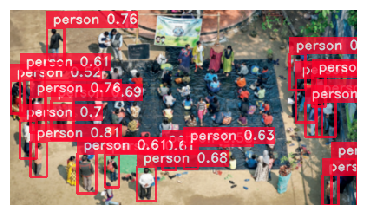

In [ ]:

img_url = 'https://static.toiimg.com/thumb/msid-89420112,imgsize-1431350,width-400,resizemode-4/89420112.jpg'
best_model.predict(img_url).show()

In [ ]:
import cv2
import numpy as np
import requests
from io import BytesIO

# URL of the image
url = "https://static.toiimg.com/thumb/msid-89420112,imgsize-1431350,width-400,resizemode-4/89420112.jpg"

# Download the image from the URL
response = requests.get(url)
img_bytes = BytesIO(response.content)
img = cv2.imdecode(np.frombuffer(img_bytes.read(), np.uint8), cv2.IMREAD_COLOR)

# Check if the image was loaded successfully
if img is not None:
    # Convert the image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Now you can continue with your code
    # (Assuming best_model is correctly defined and imported)
    # outputs = best_model.predict(img)
    # print(outputs)
    # outputs.show()
else:
    print("Failed to load the image from the URL.")


In [ ]:
 outputs = best_model.predict(img)

[2023-10-01 18:21:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


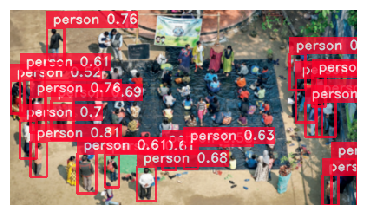

ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[174, 151, 120],
        [171, 147, 116],
        [166, 142, 112],
        ...,
        [  5,  24,  17],
        [  3,  17,  13],
        [  3,  25,  16]],

       [[179, 156, 124],
        [176, 152, 121],
        [170, 147, 117],
        ...,
        [ 18,  54,  37],
        [  8,  30,  20],
        [ 10,  43,  24]],

       [[180, 157, 126],
        [180, 156, 125],
        [176, 153, 123],
        ...,
        [ 26,  68,  40],
        [ 22,  61,  35],
        [ 27,  75,  41]],

       ...,

       [[178, 158, 121],
        [169, 149, 114],
        [166, 143, 108],
        ...,
        [ 17,  58,  73],
        [ 20,  48,  48],
        [ 27,  52,  41]],

       [[178, 158, 120],
        [172, 152, 114],
        [169, 146, 110],
        ...,
        [ 20,  62,  73],
        [ 15,  50,  43],
        [ 15,  48,  34]],

       [[176, 156, 118],
        [175, 155, 116],
        [174, 153, 115],
      

In [ ]:
print(outputs)
outputs.show()

In [ ]:
import torch
import torch.nn as nn



device = 'cuda' if torch.cuda.is_available() else "cpu"


In [ ]:
input_video_path='/content/drive/MyDrive/WhatsApp Video 2023-10-01 at 10.18.40 PM.mp4'
output_video_path='/content/result.mp4'
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 342/342 [00:05<00:00, 62.66it/s]


In [ ]:
input_video_path='/content/drive/MyDrive/WhatsApp Video 2023-09-29 at 10.42.20 PM.mp4'
output_video_path='/content/result1.mp4'
best_model.to(device).predict(input_video_path).save(output_video_path)